# EE4211 Project

- **Team Name: *Big Data Company (BDC)***

- **Team Member:**

    *Gerry Windiarto Mohamad Dunda (A0208770A)*

    *Moritz Scheer (A0210531B)*
    
    *Wang Yuzhe (A0206675Y)*
    
    *Guo Zongyi (A0206639Y)*


In this project, we will analyse natural gas consumption data from residential consumers. The smart gas meter data used for this project came from the Pecan Street project (https://www.pecanstreet.org/). The source of the data are homes in the Mueller neighborhood of Austin, Texas, USA.


## Part One: Interim Report

**Here we keep part of the code in interim report for data preprocessing**

In this part we focus on getting some basic information from the original dataset, such as the amount and outliers. Then we come up with some proposals for further study basing on the dataset.



In [2]:
import numpy as np
import sklearn.linear_model as lm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # a visualization lib based on matplotlib, more convenient and beautiful
import datetime
import math

In [3]:
df = pd.read_csv('dataport-export_gas_oct2015-mar2016.csv')
print('\nFirst, taking a look at the form of dataset:\n\n',df.head())
print(f'\nThe indices are: {df.columns}')
df_start = df.drop_duplicates(subset='dataid',keep='first',inplace=False)
df_end = df.drop_duplicates(subset='dataid',keep='last',inplace=False)
# get a list of meterID
homeid = list(df_start['dataid'])
print(f"\nTotal number of meters is : {len(df_start)}")
print(f"\nTotal number of rows is : {len(df)}")
if not df.isnull().values.any():
    print("\nThere is no data missing or 'NaN'")


First, taking a look at the form of dataset:

               localminute  dataid  meter_value
0  2015-10-01 00:00:10-05     739        88858
1  2015-10-01 00:00:13-05    8890       197164
2  2015-10-01 00:00:20-05    6910       179118
3  2015-10-01 00:00:22-05    3635       151318
4  2015-10-01 00:00:22-05    1507       390354

The indices are: Index(['localminute', 'dataid', 'meter_value'], dtype='object')

Total number of meters is : 157

Total number of rows is : 1584823

There is no data missing or 'NaN'


## 1.1 Malfunctional meters

We can see that there are **157** meters and *1584823* rows in the dataset without any "NaN" there.

Considering the reality, we propose there are three kinds of malfunction for gas meter. They are:


1. the meter reading decreases since time goes by.

2. the meter reading increase a lot between two timepoints.

3. the meter reports to the meter data management center (MDMC) less than 2 cubic.




Additioanlly, we check the starting report time for all meters and find 37 meters didn't start from October 1st, 2015. Considering that they may just move in this neighberhood, we don't take these as malfuntion.



In [4]:
print("\nCheck the report time for the last 40 meters:\n" )
# print(df_start.tail(40))

# get the id for the meters started send data later than 2015-10-01
late_id = []
for i in range(len(df_start)):
    start_day = df_start.iloc[i]['localminute'][8:10]
    if start_day != '01':
        late_id.append(df_start.iloc[i]['dataid'])
        
print(f'\nThere are {len(late_id)} meters sending data later than 2015-10-01.')


Check the report time for the last 40 meters:


There are 37 meters sending data later than 2015-10-01.


#### 1.1.1 The meter reading decreases since time goes by.

In [5]:
dec_change = pd.DataFrame(columns=['localminute','dataid','meter_value'])
inc_huge = pd.DataFrame(columns=['localminute','dataid','meter_value'])

for i in homeid:
    # print(i)
    df_home = df[df['dataid']==i]
    readings = list(df_home['meter_value'])
    
    for j in range(len(df_home)-1):
        if (readings[j+1] - readings[j]) < 0:
            dec_change = dec_change.append(df_home.iloc[j:j+2])
        if (readings[j+1] - readings[j]) >= 200:
            inc_huge = inc_huge.append(df_home.iloc[j:j+2])


In [6]:
dec_start = dec_change.drop_duplicates(subset='dataid',keep='first',inplace=False)
# dec_id = list(dec_start['dataid'])
print(f"\nIn total, {len(dec_start)} meters have decreasing values.")
print("\nHere are the meters that occurs decreasing value and the corresponding times.\n")
dec_times = dec_change.pivot_table(index=['dataid'],aggfunc='size')
for row in dec_times.iteritems():
    print('ID:',row[0],' Times:', int(row[1]/2), end='\t')


In total, 43 meters have decreasing values.

Here are the meters that occurs decreasing value and the corresponding times.

ID: 35  Times: 1	ID: 77  Times: 1	ID: 94  Times: 6	ID: 483  Times: 1	ID: 484  Times: 9	ID: 1042  Times: 1	ID: 1086  Times: 1	ID: 1185  Times: 135	ID: 1507  Times: 2	ID: 1556  Times: 12	ID: 1718  Times: 4	ID: 1790  Times: 1	ID: 1801  Times: 1	ID: 2129  Times: 3	ID: 2335  Times: 5	ID: 2449  Times: 93	ID: 3134  Times: 18	ID: 3527  Times: 1	ID: 3544  Times: 18	ID: 3893  Times: 2	ID: 4031  Times: 16	ID: 4193  Times: 1	ID: 4514  Times: 141	ID: 4998  Times: 1	ID: 5129  Times: 76	ID: 5131  Times: 1	ID: 5193  Times: 4	ID: 5403  Times: 156	ID: 5810  Times: 10	ID: 5814  Times: 1	ID: 5892  Times: 1	ID: 6836  Times: 51	ID: 7017  Times: 1	ID: 7030  Times: 90	ID: 7117  Times: 123	ID: 7739  Times: 1	ID: 7794  Times: 1	ID: 7989  Times: 2	ID: 8156  Times: 151	ID: 8890  Times: 44	ID: 9134  Times: 115	ID: 9639  Times: 2	ID: 9982  Times: 2	

Consider more than 10 times is malfunction (and drop half of them, which are decreasing values, for the forecasting in the second question). 

In [7]:
# We consider data increasing more than 10 times will be dropped
drop_indices = list(dec_times.where(dec_times/2 > 10).dropna().index)
print(f'\n{len(drop_indices)} meters have decreasing readings more than 10 times. They are:')
print('\n', drop_indices)
print('\nTake 1185 as an example, check the decreasing readings:\n')
dec_exa = dec_change[dec_change['dataid']==1185]
print(dec_exa.head(10))


15 meters have decreasing readings more than 10 times. They are:

 [1185, 1556, 2449, 3134, 3544, 4031, 4514, 5129, 5403, 6836, 7030, 7117, 8156, 8890, 9134]

Take 1185 as an example, check the decreasing readings:

                   localminute dataid meter_value
143717  2015-10-17 10:50:54-05   1185      139798
143720  2015-10-17 10:51:09-05   1185      139796
143782  2015-10-17 10:59:49-05   1185      139798
143836  2015-10-17 11:08:06-05   1185      139796
144068  2015-10-17 11:43:41-05   1185      139800
144087  2015-10-17 11:47:03-05   1185      139798
144386  2015-10-17 12:31:41-05   1185      139806
144399  2015-10-17 12:33:57-05   1185      139802
144586  2015-10-17 13:03:51-05   1185      139812
144745  2015-10-17 13:27:01-05   1185      139806


In [8]:
# save all the indices for readings that to be dropped in a list
idx_drop = []
for idx in drop_indices:
    df_idx = dec_change[dec_change['dataid']== idx][::-2]
    idx_drop.append(df_idx.index)

d = dec_exa.drop(dec_exa[dec_exa['dataid']==1185][::-2].index)
print('\nDelete the decreasing readings and check 1185 again:\n')
print(d.head(5))


Delete the decreasing readings and check 1185 again:

                   localminute dataid meter_value
143717  2015-10-17 10:50:54-05   1185      139798
143782  2015-10-17 10:59:49-05   1185      139798
144068  2015-10-17 11:43:41-05   1185      139800
144386  2015-10-17 12:31:41-05   1185      139806
144586  2015-10-17 13:03:51-05   1185      139812


#### 1.1.2 The meter reading increase a lot in a short time period.

Take larger that 200 cubics increase between two adjacent records as an outlier.


In [9]:
# "inc_huge" is the data frame where two adjacent records are lager tahn 200 cubics. 
inc_start = inc_huge.drop_duplicates(subset='dataid',keep='first',inplace=False)
print(f"\n There are {len(inc_start)} meters has outlier.")
print("\n Take a brief look at 10 outliers of some meters.")
print(inc_huge.head(20))


 There are 93 meters has outlier.

 Take a brief look at 10 outliers of some meters.
                           localminute dataid meter_value
609165          2015-12-07 23:41:42-06   3635      155548
618896          2015-12-09 00:26:36-06   3635      155788
732234   2015-12-21 00:29:14.700727-06   4352      223624
1132977  2016-02-04 13:18:31.172764-06   4352      233896
1154982  2016-02-06 22:15:47.473284-06   4352      234414
1159974   2016-02-07 11:23:17.30182-06   4352      234672
1422869  2016-03-08 18:09:51.535581-06   4352      236952
1464967  2016-03-14 18:47:32.658793-05   4352      237172
1491179  2016-03-18 11:27:23.980261-05   4352      237230
1515940   2016-03-21 21:41:15.66264-05   4352      237674
541075          2015-11-30 14:06:12-06   6412      136212
553260          2015-12-01 23:00:42-06   6412      136660
606180          2015-12-07 16:35:44-06   8156      256346
606194   2015-12-07 16:37:39.855453-06   8156      274146
606479          2015-12-07 17:18:44-06   815

Apparently, there are two kinds of outliers.

One is report period is much longer, but the value make sense.

The other one just alternate between two values, such as "8156". These kind of meter will be considered as malfunction.


In [10]:
outliers = pd.DataFrame(columns=['localminute','dataid','meter_value'])
for i in homeid:
    # print(i)
    df_home = df[df['dataid']==i]
    readings = list(df_home['meter_value'])

    for j in range(len(df_home)-2):
        if (readings[j] - readings[j-1]) >= 1500:
            outliers = outliers.append(df_home.iloc[j])
        elif (readings[j+1] - readings[j-1]) >= 1500:
            outliers = outliers.append(df_home.iloc[j+1])
        elif (readings[j+2] - readings[j-1])>=1500:
            outliers = outliers.append(df_home.iloc[j+2])
outliers = outliers.iloc[~outliers.index.duplicated(keep='first')]

In [11]:
out_start = outliers.drop_duplicates(subset='dataid',keep='first',inplace=False)
out_times = outliers.pivot_table(index=['dataid'],aggfunc='size')
print('\n Here are the meters that occurs outliers and the corresponding times.\n')
for row in out_times.iteritems():
    print('ID:',row[0],' Times:', row[1], end='\t')


 Here are the meters that occurs outliers and the corresponding times.

ID: 222  Times: 11	ID: 1185  Times: 125	ID: 1556  Times: 10	ID: 2233  Times: 2	ID: 2335  Times: 4	ID: 2378  Times: 2	ID: 2449  Times: 91	ID: 2638  Times: 1	ID: 2645  Times: 2	ID: 2814  Times: 2	ID: 2818  Times: 4	ID: 3039  Times: 2	ID: 3134  Times: 17	ID: 3544  Times: 18	ID: 4193  Times: 2	ID: 4352  Times: 1	ID: 4421  Times: 1	ID: 4447  Times: 1	ID: 4514  Times: 126	ID: 4671  Times: 1	ID: 5129  Times: 73	ID: 5403  Times: 136	ID: 5545  Times: 2	ID: 6505  Times: 5	ID: 6578  Times: 1	ID: 6685  Times: 3	ID: 6836  Times: 50	ID: 6863  Times: 4	ID: 7030  Times: 79	ID: 7117  Times: 111	ID: 7460  Times: 1	ID: 7919  Times: 1	ID: 7965  Times: 2	ID: 8059  Times: 1	ID: 8156  Times: 139	ID: 8467  Times: 1	ID: 8703  Times: 5	ID: 9134  Times: 111	ID: 9474  Times: 1	ID: 9620  Times: 4	ID: 9639  Times: 2	ID: 9956  Times: 2	ID: 9982  Times: 2	

In [12]:
drop_indices = list(out_times.index)
print(f'\n{len(drop_indices)} meters have outliers will be dropped).')

for idx in drop_indices:
    df_idx = inc_huge[inc_huge['dataid']== idx]
    # append indices to the dropped-index-list
    idx_drop.append(df_idx.index)

print('\nNow check the readings for 8156 when outliers removed:\n')
dec_exa = inc_huge[inc_huge['dataid']==8156]
d = dec_exa.drop(dec_exa[dec_exa['dataid']==8156][::-2].index)
print(d.head(10))
# df_dropped is the dataframe


43 meters have outliers will be dropped).

Now check the readings for 8156 when outliers removed:

                   localminute dataid meter_value
606180  2015-12-07 16:35:44-06   8156      256346
606479  2015-12-07 17:18:44-06   8156      256346
606645  2015-12-07 17:42:44-06   8156      256346
606788  2015-12-07 18:04:44-06   8156      256346
607026  2015-12-07 18:37:44-06   8156      256348
607236  2015-12-07 19:05:45-06   8156      256350
607286  2015-12-07 19:11:45-06   8156      256350
607531  2015-12-07 19:44:44-06   8156      256352
608062  2015-12-07 20:59:44-06   8156      256352
608507  2015-12-07 22:03:45-06   8156      256352


#### 1.1.3 The meter reports to the meter data management center (MDMC) less than 2 cubic.

In [13]:
between_value = pd.DataFrame(columns=['localminute','dataid','meter_value'])
for i in homeid:
    # print(i)
    df_home = df[df['dataid']==i]
    readings = list(df_home['meter_value'])
    
    for j in range(len(df_home)-1):
        if (readings[j+1] - readings[j]) > 0 and (readings[j+1] - readings[j]) < 2:
            between_value = between_value.append(df_home.iloc[j:j+2])
if between_value.empty:
    print("\nThere is no meter reported when the readings increase less than 2.")
if not between_value.empty:
    print(between_value)


There is no meter reported when the readings increase less than 2.


#### Drop all the malfunctioning readings basing on above analysis

In [14]:
# "idx_drop" save all the indices where readings need to be dropped
drop_list = []
for i in range(len(idx_drop)):
    drop_list.extend(idx_drop[i].tolist())
    
df_dropped = df.drop(drop_list)
print(f'After dropped, the amount of readings changes from {len(df)} to {len(df_dropped)}.')

After dropped, the amount of readings changes from 1584823 to 1581145.


## 1.2 Generating hourly readings

Select one month from the 6-month study interval and plot the hourly readings (time-series) for that month.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as lm

df_original = pd.read_csv('dataport-export_gas_oct2015-mar2016.csv')
df = df_original
df.columns = ['date', 'id', 'measurement']

In [16]:
year = []
month = []
day = []
hour = []
minute = []
sec = []
absolute_sec = []


for i in range (len(df.date)):
    str_object = df.at[i, 'date']
    year.append(int(str_object[:4]))
    month.append(int(str_object[5:7]))
    day.append(int(str_object[8:10]))
    hour.append(int(str_object[11:13]))
    minute.append(int(str_object[14:16]))
    sec.append(int(str_object[17:19]))
    
    abs_sec = sec[i] + 60*minute[i] + 60*60*hour[i] + 24*60*60*(day[i] - 1)  
    if (month[i] == 10):   
        abs_sec += 0
    elif (month[i] == 11):
        abs_sec += 31*24*60*60
    elif (month[i] == 12):
        abs_sec += (30+31)*24*60*60
    elif (month[i] == 1):
        abs_sec += (31+30+31)*24*60*60
    elif (month[i] == 2):
        abs_sec += (31+31+30+31)*24*60*60
    elif (month[i] == 3):
        abs_sec += (29+31+31+30+31)*24*60*60
    absolute_sec.append(abs_sec) 
    

df.insert(1, 'year', year, allow_duplicates = True)
df.insert(2, 'month', month, allow_duplicates = True)
df.insert(3, 'day', day, allow_duplicates = True)
df.insert(4, 'hour', hour, allow_duplicates = True)
df.insert(5, 'minute', minute, allow_duplicates = True)
df.insert(6, 'sec', sec, allow_duplicates = True)
df.insert(7, 'absolute_sec', absolute_sec, allow_duplicates = True)

In [17]:
def plotSamples_IDandMonth(df, id, month):
    df = df.loc[(df['id'] == id) & (df['month'] == month)]
    x = df.absolute_sec.tolist()
    y = df.measurement.tolist()
    
    for i in range (len(x)):
        x[i] /= 60*60
    
    plt.scatter(x, y)

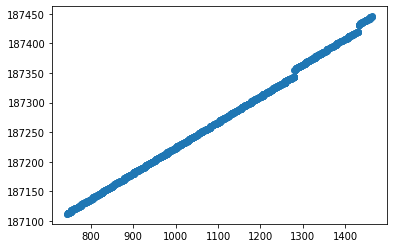

In [18]:
plotSamples_IDandMonth(df, 8967, 11)

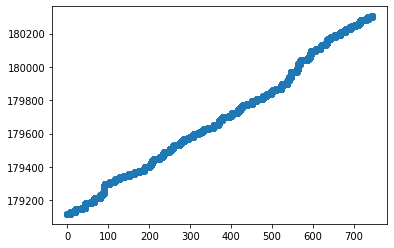

In [19]:
plotSamples_IDandMonth(df, 6910, 10)

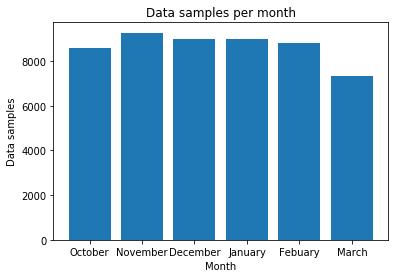

In [20]:
df_october = df.loc[df['month'] == 10]
df_november = df.loc[df['month'] == 11]
df_december = df.loc[df['month'] == 12]
df_january = df.loc[df['month'] == 1]
df_febuary = df.loc[df['month'] == 2]
df_march = df.loc[df['month'] == 3]
x = ['October', 'November', 'December', 'January', 'Febuary', 'March']
y = [len(df_october)/31, len(df_november)/30, len(df_december)/31, len(df_january)/31, len(df_febuary)/29, 
     len(df_march)/31]

index = np.arange(len(x))
plt.bar(x, y)
plt.xlabel('Month')
plt.ylabel('Data samples')
plt.title('Data samples per month')
plt.show()

In [21]:
bm = 11 

In [22]:
def getXrange(month):
    x = []
    if month == 10:
        x = range(0, 31*24)
    elif month == 11:
        x = range(31*24, (31+30)*24)
    elif month == 12:
        x = range((31+30)*24, (31+30+31)*24)
    elif month == 1:
        x = range((31+30+31)*24, (31+30+31+31)*24)
    elif month == 2:
        x = range((31+30+31+31)*24, (31+30+31+31+29)*24)
    elif month == 3:
        x = range((31+30+31+31+29)*24, (31+30+31+31+29+31)*24)
    return x

In [23]:
from scipy import interpolate

def hourlyReadings_IDandMonth(df, id, month):
    df_correct = df.loc[(df['id'] == id) & (df['month'] == month)]
    
    x = df_correct.absolute_sec
    y = df_correct.measurement
        
    tck = interpolate.splrep(x, y, k=1)
    
    hourly_readings = []
            
    for i in (getXrange(month)):
        hourly_readings.append(interpolate.splev(i*60*60, tck))
        
    return hourly_readings

In [24]:
def hourlyReadings_Month(df, month):
    hourly_readings_month = {}

    for x in set(df.id):           #manche ids produzieren wohl Fehler "m > k must hold"
        hourly_readings_month[x] = hourlyReadings_IDandMonth(df, x, bm)
        
    return hourly_readings_month

In [25]:
def plottingOneID(df, id, month):
    if month == 10 or month == 12 or month == 1 or month == 3:
        x = range(0, 31*24)
    elif month == 11:
        x = range(0, 30*24)
    elif month == 2:
        x = range(0, 29*24)

    y = hourlyReadings_IDandMonth(df, id, month)
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(x, y, '-')
    ax.set_xlim(0, 31*24)
    ax.set_title('Hourly reading of Household {} for month {}'.format(id, month))
    plt.xlabel("Hour")
    plt.ylabel("Measurement")
    plt.grid()    

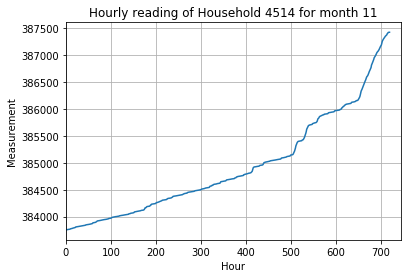

In [26]:
import random

plottingOneID(df, random.sample(set(df.loc[df['month'] == bm].id),  1)[0], bm)

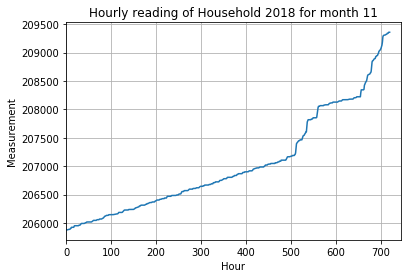

In [27]:
id = random.sample(set(df.loc[df['month'] == bm].id),  1)[0]
plottingOneID(df, id, bm)

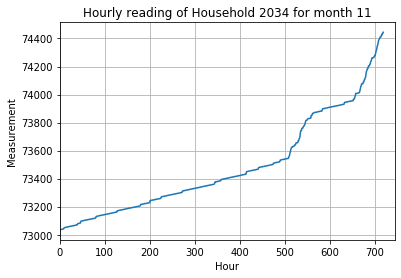

In [28]:
plottingOneID(df, random.sample(set(df.loc[df['month'] == bm].id),  1)[0], bm)

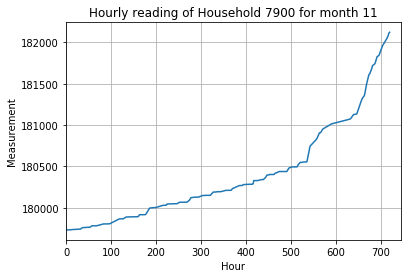

In [29]:
plottingOneID(df, random.sample(set(df.loc[df['month'] == bm].id),  1)[0], bm)

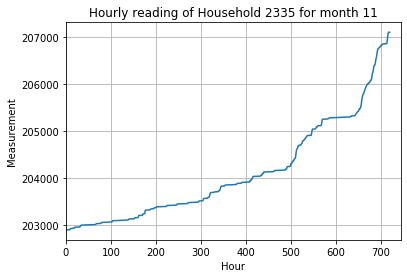

In [30]:
plottingOneID(df, random.sample(set(df.loc[df['month'] == bm].id), 1)[0], bm)

In [31]:
def plottingThreeID(df, ids, month):
    if month == 10 or month == 12 or month == 1 or month == 3:
        x = range(0, 31*24)
    elif month == 11:
        x = range(0, 30*24)
    elif month == 2:
        x = range(0, 29*24)

    y1 = hourlyReadings_IDandMonth(df, ids[0], month)  
    y2 = hourlyReadings_IDandMonth(df, ids[1], month)
    y3 = hourlyReadings_IDandMonth(df, ids[2], month)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(x, y1, '--k', label = ids[0])
    ax.plot(x, y2, '-', label = ids[1])
    ax.plot(x, y3, '-.', label = ids[2])
    ax.legend()
    ax.set_xlim(0, 31*24)
    ax.set_title('Hourly reading for month {}'.format(month))
    plt.xlabel("Hour")
    plt.ylabel("Measurement")
    plt.grid()
    plt.show()
    

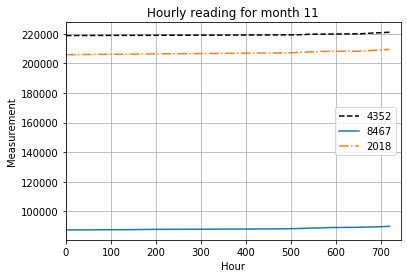

In [32]:
plottingThreeID(df, random.sample(set(df.loc[df['month'] == bm].id),  3), bm)

In [33]:
def plottingChangesThreeID(df, ids, month):
    if month == 10 or month == 12 or month == 1 or month == 3:
        x = range(0, 31*24)
    elif month == 11:
        x = range(0, 30*24)
    elif month == 2:
        x = range(0, 29*24)

    y1 = hourlyReadings_IDandMonth(df, ids[0], month)  
    y2 = hourlyReadings_IDandMonth(df, ids[1], month)
    y3 = hourlyReadings_IDandMonth(df, ids[2], month)
    
    print
    
    y = [y1, y2, y3]
    
    for y_i in y:
        too_much = y_i[0]
        for j in range (len(y_i)):
            y_i[j] = y_i[j] - too_much
            
    y1 = y[0]
    y2 = y[1]
    y3 = y[2]
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(x, y1, '--k', label = ids[0])
    ax.plot(x, y2, '-', label = ids[1])
    ax.plot(x, y3, '-.', label = ids[2])
    ax.legend()
    ax.set_xlim(0, 31*24)
    ax.set_title('Reset, hourly reading for month {}'.format(month))
    plt.xlabel("Hour")
    plt.ylabel("Measurement")
    plt.grid()
    plt.show()

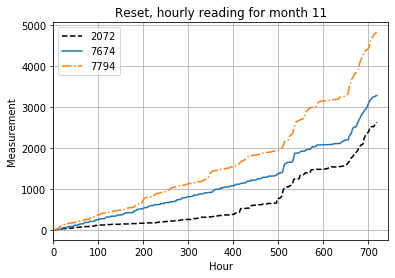

In [34]:
plottingChangesThreeID(df, random.sample(set(df.loc[df['month'] == bm].id),  3), bm)

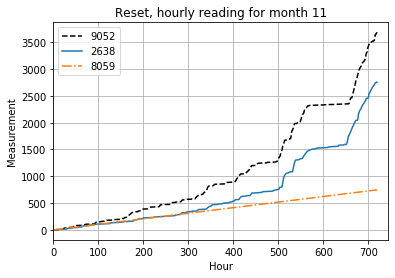

In [35]:
plottingChangesThreeID(df, random.sample(set(df.loc[df['month'] == bm].id),  3), bm)

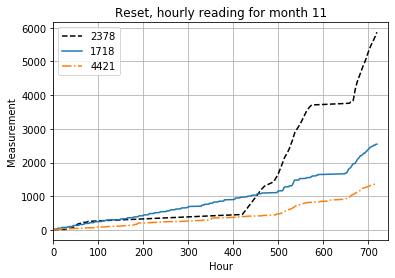

In [36]:
plottingChangesThreeID(df, random.sample(set(df.loc[df['month'] == bm].id),  3), bm)

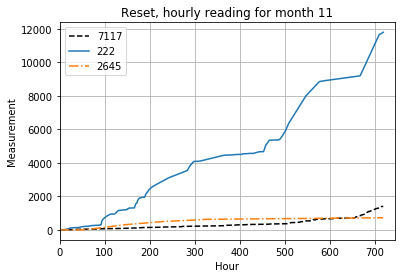

In [37]:
plottingChangesThreeID(df, random.sample(set(df.loc[df['month'] == bm].id),  3), bm)

## 1.3 Correlation Analysis

In [42]:
import datetime as dt
# df['date'] = pd.to_datetime(df['date'],  format="%Y/%m/%d %H:%M:%S") 
df['date'] = df['date'].apply(lambda x: 
                                    dt.datetime.strptime(x[:19],'%Y-%m-%d %H:%M:%S'))
df.set_index('date')
df.dtypes

date            datetime64[ns]
year                     int64
month                    int64
day                      int64
hour                     int64
minute                   int64
sec                      int64
absolute_sec             int64
id                       int64
measurement              int64
dtype: object

In [43]:
from collections import defaultdict
import sys
series = defaultdict(int)
length = len(list(df.drop_duplicates(subset='id',keep='first',inplace=False)['id']))
i = 1
ids = []
for dataid in list(df.drop_duplicates(subset='id',keep='first',inplace=False)['id']):
    #print("progress = " + str(i) + "/" + str(length))
    #sys.stdout.flush()
    series_id = pd.Series(list(df[df.id == dataid]['measurement']),index = list(df[df.id == dataid]['date']))
    #series_id = series_id.between_time(dt.datetime.strptime('2015-10-01 00:00:00','%Y-%m-%d %H:%M:%S'),dt.datetime.strptime('2015-11-01 00:00:00','%Y-%m-%d %H:%M:%S'))
    mask = (series_id.index >= '2015-11-01') & (series_id.index <= '2015-12-01')
    series_id = series_id.loc[mask]
    series_id = series_id.resample('H').mean()
    series_id = series_id.interpolate(method='time')
    if(len(series_id) != 720):
        i += 1
        continue
    series[dataid] = list(series_id)
    ids.append(dataid)
    i += 1


In [44]:
results = pd.DataFrame()
for dataid, measure in series.items():
#     print("id: " + str(dataid) + " has length = " + str(len(measure)))
    results = pd.concat([results,pd.Series(measure).rename(str(dataid))],axis = 1)
    


In [45]:
#This table shows the correlation
results.corr()

739      8890      6910      1507      5810       484      4352  \
739   1.000000  0.963237  0.997323  0.992936  0.993143  0.995816  0.939721   
8890  0.963237  1.000000  0.974763  0.983516  0.945282  0.955476  0.995138   
6910  0.997323  0.974763  1.000000  0.995889  0.987687  0.992450  0.954908   
1507  0.992936  0.983516  0.995889  1.000000  0.986760  0.991522  0.965540   
5810  0.993143  0.945282  0.987687  0.986760  1.000000  0.997291  0.915704   
484   0.995816  0.955476  0.992450  0.991522  0.997291  1.000000  0.928016   
4352  0.939721  0.995138  0.954908  0.965540  0.915704  0.928016  1.000000   
1718  0.996982  0.971582  0.995272  0.995203  0.991993  0.994104  0.951371   
1714  0.976209  0.982116  0.985001  0.990724  0.968230  0.976320  0.969264   
5131  0.959318  0.992617  0.968382  0.975021  0.936153  0.949619  0.990787   
7429  0.981914  0.960526  0.981143  0.976038  0.967561  0.970112  0.948375   
871   0.940175  0.986378  0.954212  0.959973  0.908923  0.927619  0.986743   
1086  0.994999  0.980536  0.996994  0.998164  0.986431  0.992992  0.961277   
1589  0.985037  0.993280  0.991253  0.996471  0.972695  0.980297  0.981569   
8156  0.993215  0.985142  0.996061  0.997511  0.982597  0.988491  0.970248   
5403  0.994232  0.955727  0.991350  0.992180  0.998466  0.998640  0.928347   
4447  0.973295  0.992451  0.979129  0.989853  0.965290  0.972591  0.981963   
2034  0.990160  0.988613  0.995428  0.998445  0.980001  0.986430  0.974629   
7794  0.995075  0.980075  0.996003  0.998216  0.989136  0.993084  0.961898   
7287  0.992135  0.947289  0.985781  0.985322  0.996559  0.994510  0.921245   
9639  0.997573  0.971645  0.996967  0.995984  0.992890  0.996215  0.948405   
7017  0.972353  0.997591  0.981285  0.986345  0.953373  0.962320  0.992184   
252   0.981635  0.994439  0.988640  0.991646  0.963433  0.973902  0.984730   
8829  0.983506  0.991419  0.988426  0.992458  0.969956  0.975550  0.982280   
94    0.986717  0.983249  0.991184  0.992332  0.973841  0.984809  0.965961   
9121  0.995597  0.980175  0.997283  0.998748  0.987940  0.993788  0.960299   
7741  0.982585  0.977990  0.982816  0.988822  0.977569  0.979421  0.965679   
7674  0.996136  0.977577  0.996634  0.997115  0.989836  0.992588  0.959165   
7030  0.991293  0.966793  0.988002  0.988260  0.986869  0.986425  0.948719   
4732  0.979605  0.995223  0.987269  0.991963  0.962782  0.973075  0.984982   
...        ...       ...       ...       ...       ...       ...       ...   
8155  0.984482  0.990016  0.990672  0.991793  0.966967  0.978133  0.976465   
483   0.952028  0.995051  0.962713  0.971249  0.928782  0.940226  0.996351   
4029  0.973496  0.979625  0.975016  0.980923  0.964133  0.967025  0.971611   
1791  0.990929  0.944611  0.986361  0.987032  0.998204  0.996610  0.915667   
1801  0.992399  0.981047  0.994441  0.998180  0.989012  0.991636  0.963651   
1283  0.996091  0.958945  0.995083  0.992550  0.993439  0.996811  0.933495   
3893  0.991526  0.981749  0.993051  0.996646  0.985979  0.989523  0.965722   
1185  0.971647  0.993841  0.978078  0.986499  0.958264  0.964999  0.988299   
2638  0.977561  0.996083  0.985691  0.989261  0.958051  0.969189  0.987730   
3723  0.993711  0.982676  0.996494  0.997721  0.983572  0.991303  0.964023   
4514  0.992538  0.986825  0.994785  0.997857  0.983392  0.988350  0.971326   
5814  0.988075  0.992099  0.993555  0.996845  0.975349  0.982953  0.978625   
4421  0.986224  0.992625  0.992465  0.996837  0.976084  0.982170  0.979332   
661   0.996323  0.978826  0.997919  0.997911  0.989090  0.993804  0.958496   
3134  0.997554  0.970836  0.996123  0.995043  0.992721  0.995432  0.947577   
6836  0.989172  0.936221  0.981284  0.973721  0.984688  0.983384  0.913146   
5484  0.993803  0.931321  0.985954  0.978887  0.995843  0.994198  0.899704   
2072  0.970548  0.992929  0.981072  0.983474  0.947563  0.961731  0.985303   
2461  0.976292  0.993868  0.984810  0.992574  0.965909  0.973879  0.984535   
744   0.995095  0.977484  0.99534

In [46]:
dfc = results.corr().stack().reset_index()
dfc['level_0'] = pd.to_numeric(dfc['level_0'])
dfc['level_1'] = pd.to_numeric(dfc['level_1'])
dfc.set_index('level_0',inplace= True)
#dfc[dfc.level_0 == '1185']
# dfc.columns[0]

In [47]:
#dfc.sort_values(by=['level_0','level_1',dfc.columns[2]], ascending=[False,False,True]).groupby('level_0').head(5).values
pd.set_option('display.max_rows', 20)
dfc.groupby('level_1')[dfc.columns[1]].apply(lambda grp: grp.nlargest(5))



level_1  level_0
94       94         1.000000
         8155       0.997925
         3723       0.997296
         1086       0.996198
         9052       0.995773
252      252        1.000000
         2638       0.999222
         4732       0.998485
         3577       0.998024
         5814       0.997860
                      ...   
9474     9474       1.000000
         4998       0.997633
         7741       0.997537
         4514       0.997325
         3893       0.996829
9639     9639       1.000000
         661        0.999063
         3134       0.998922
         9134       0.998818
         9121       0.997846
Name: 0, Length: 385, dtype: float64

## 2.2 Forecasting using linear regression

Build a linear regression model to forecast the hourly readings in the future (next
hour). Generate two plots: (i) Time series plot of the actual and predicted hourly
meter readings and (ii) Scatter plot of actual vs predicted meter readings (along
with the line showing how good the it is).

In [48]:
import math
#@return: X_train, X_pred, Y_train, Y_act
def data_split(X,Y,train_frac):
    return X[:math.floor(train_frac*len(X))], X[math.floor(train_frac*len(X)):], Y[:math.floor(train_frac*len(X))],Y[math.floor(train_frac*len(X)):]
    

/Applications/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


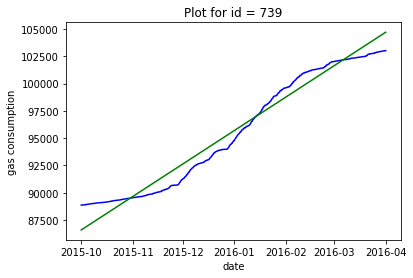

<Figure size 2160x2160 with 0 Axes>

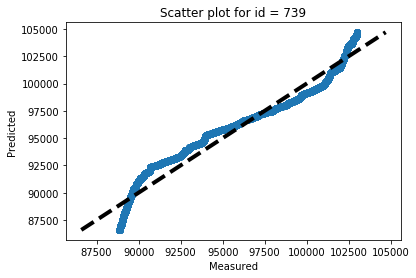

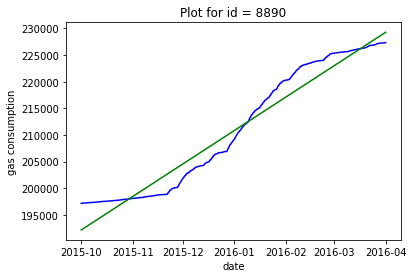

<Figure size 2160x2160 with 0 Axes>

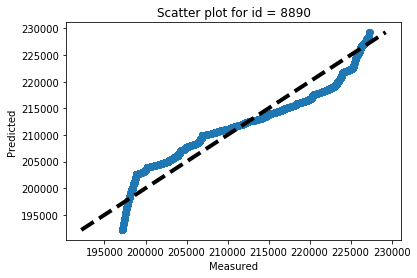

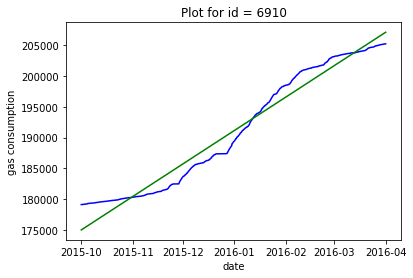

<Figure size 2160x2160 with 0 Axes>

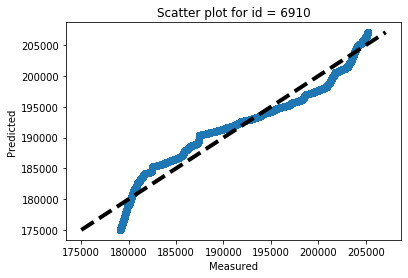

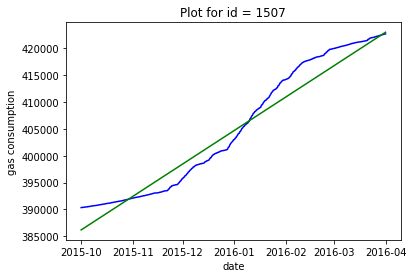

<Figure size 2160x2160 with 0 Axes>

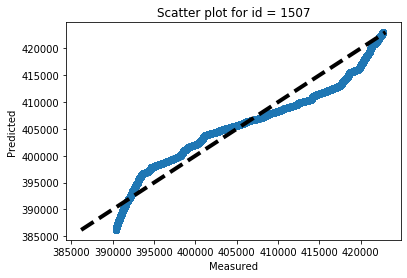

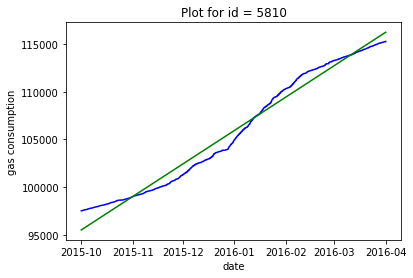

<Figure size 2160x2160 with 0 Axes>

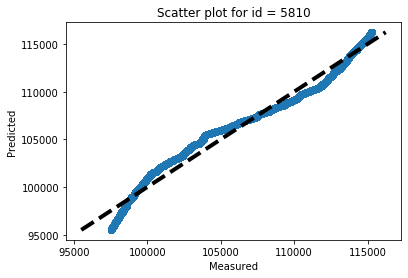

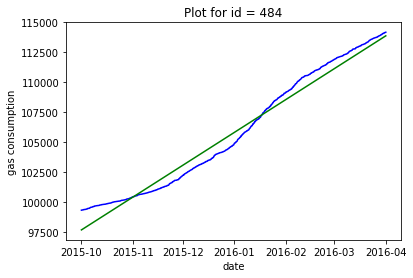

<Figure size 2160x2160 with 0 Axes>

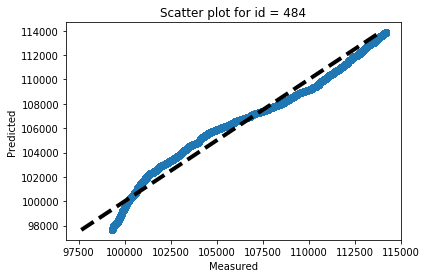

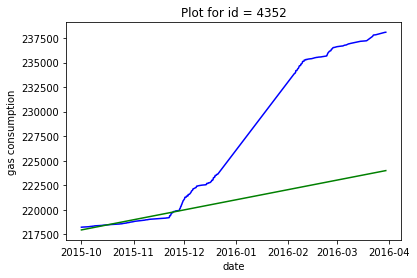

<Figure size 2160x2160 with 0 Axes>

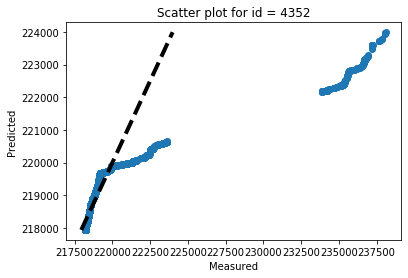

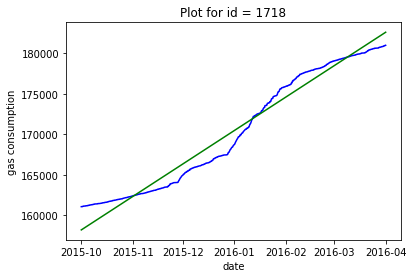

<Figure size 2160x2160 with 0 Axes>

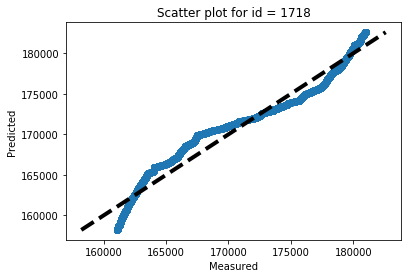

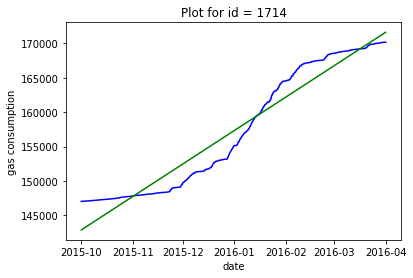

<Figure size 2160x2160 with 0 Axes>

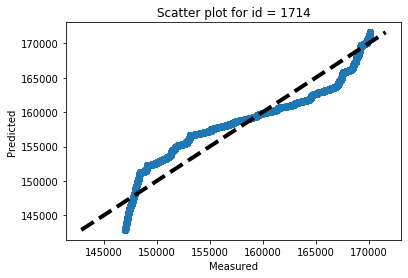

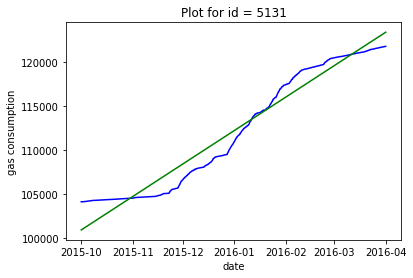

<Figure size 2160x2160 with 0 Axes>

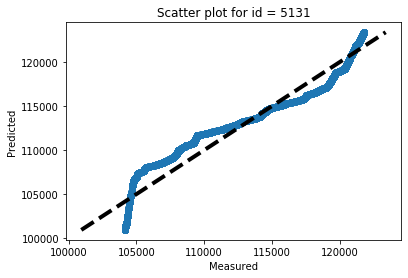

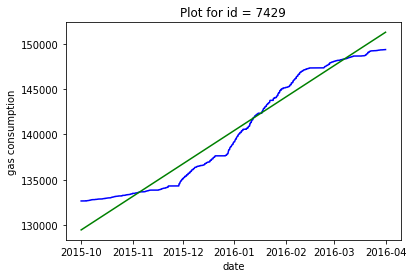

<Figure size 2160x2160 with 0 Axes>

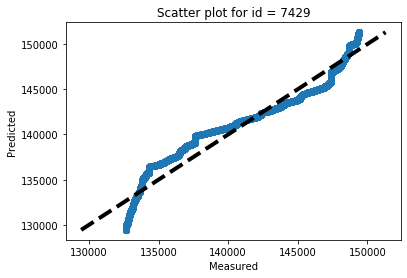

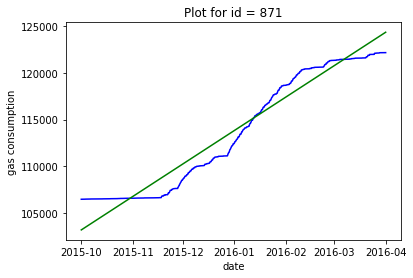

<Figure size 2160x2160 with 0 Axes>

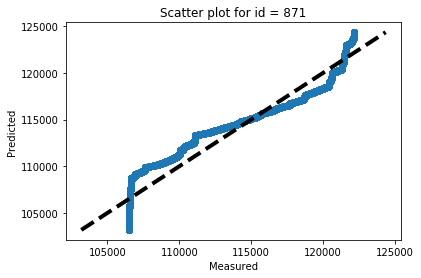

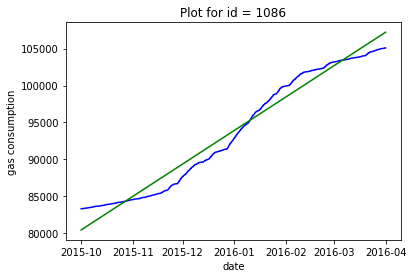

<Figure size 2160x2160 with 0 Axes>

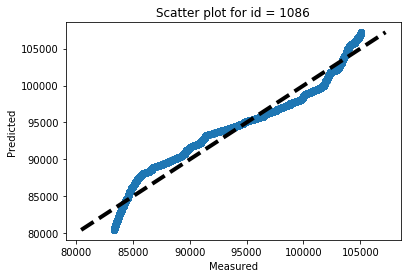

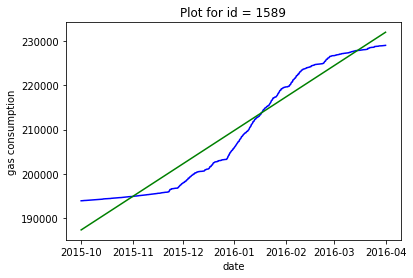

<Figure size 2160x2160 with 0 Axes>

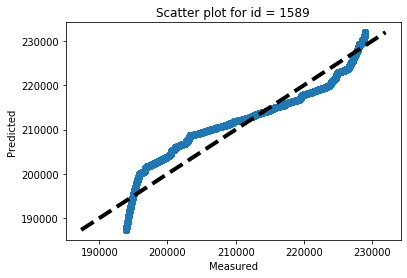

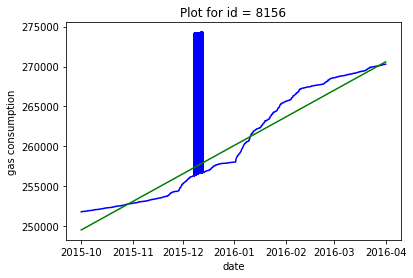

<Figure size 2160x2160 with 0 Axes>

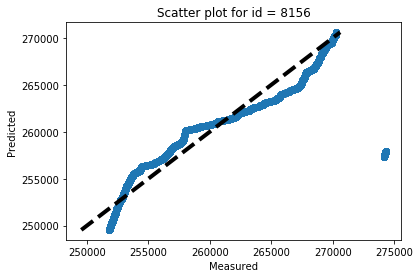

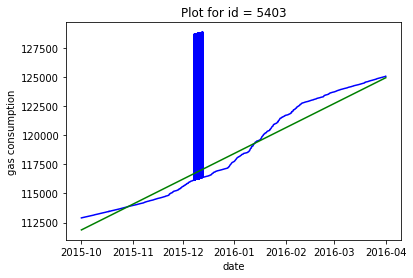

<Figure size 2160x2160 with 0 Axes>

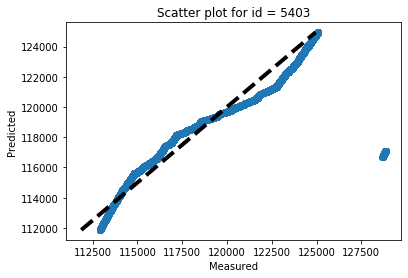

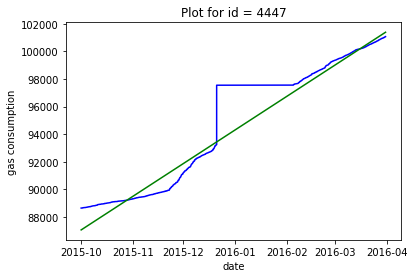

<Figure size 2160x2160 with 0 Axes>

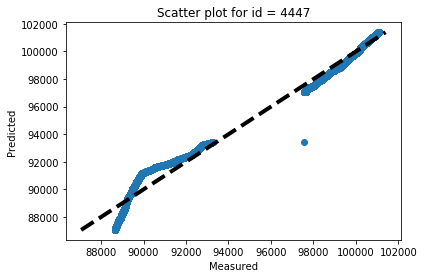

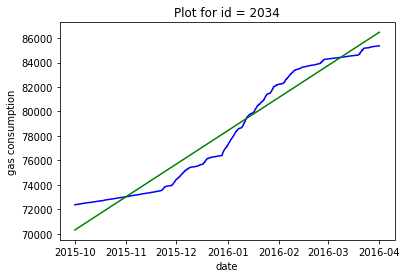

<Figure size 2160x2160 with 0 Axes>

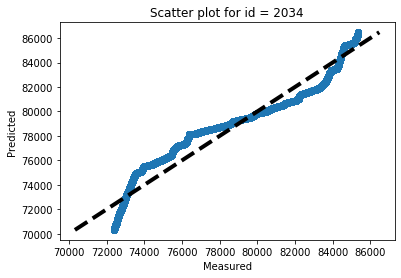

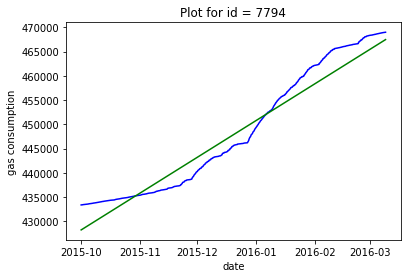

<Figure size 2160x2160 with 0 Axes>

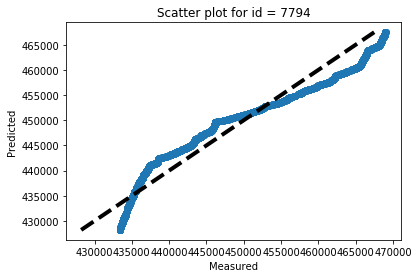

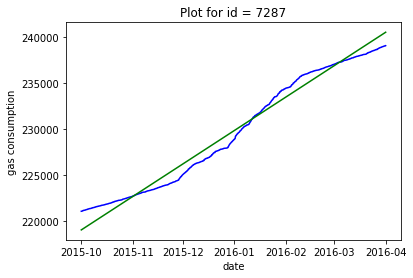

<Figure size 2160x2160 with 0 Axes>

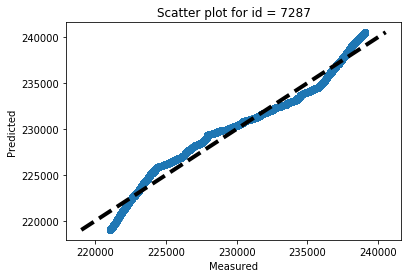

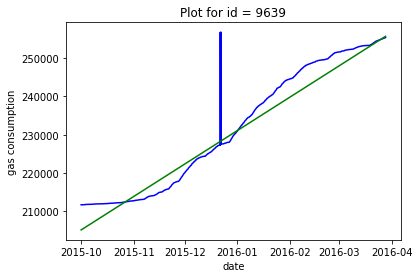

<Figure size 2160x2160 with 0 Axes>

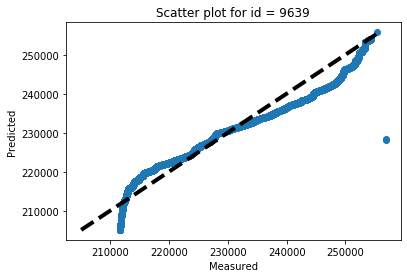

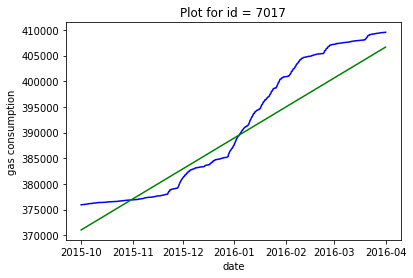

<Figure size 2160x2160 with 0 Axes>

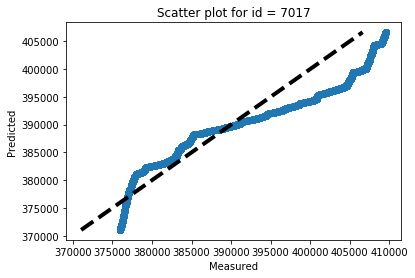

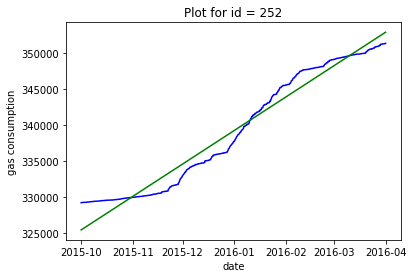

<Figure size 2160x2160 with 0 Axes>

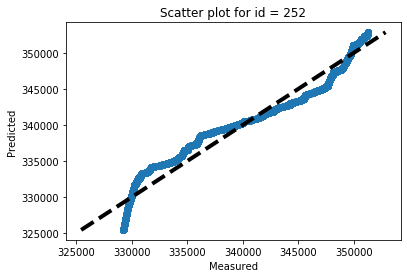

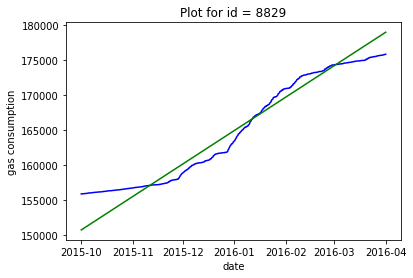

<Figure size 2160x2160 with 0 Axes>

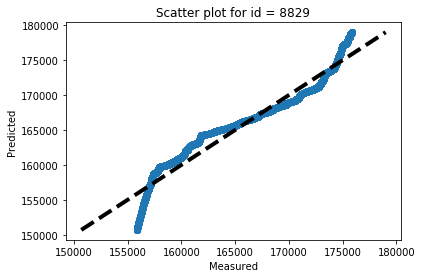

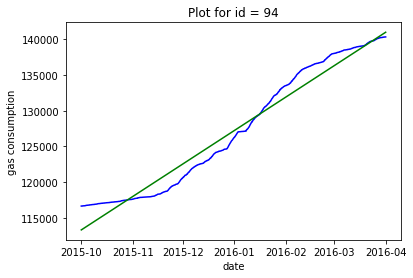

<Figure size 2160x2160 with 0 Axes>

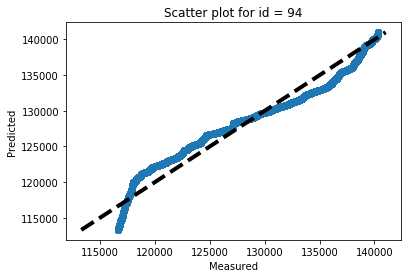

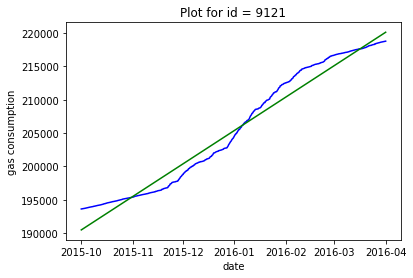

<Figure size 2160x2160 with 0 Axes>

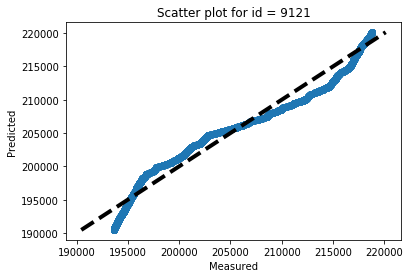

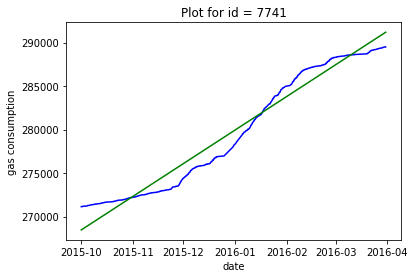

<Figure size 2160x2160 with 0 Axes>

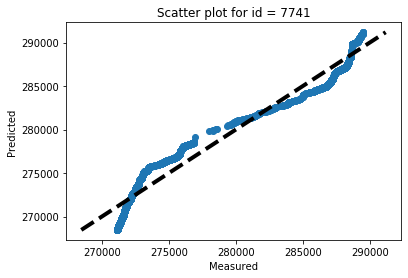

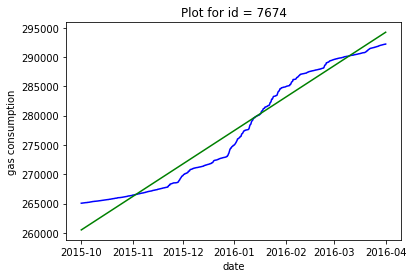

<Figure size 2160x2160 with 0 Axes>

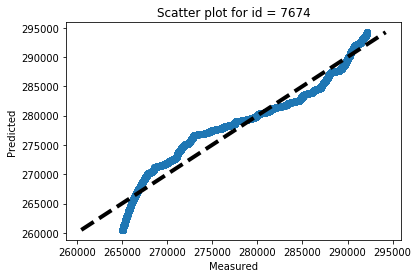

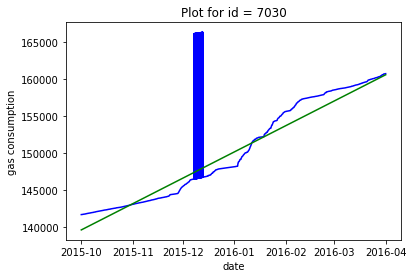

<Figure size 2160x2160 with 0 Axes>

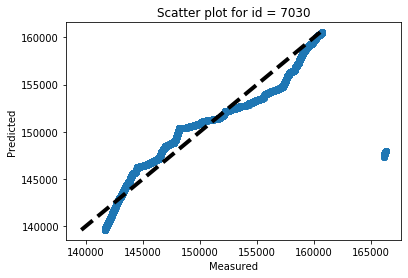

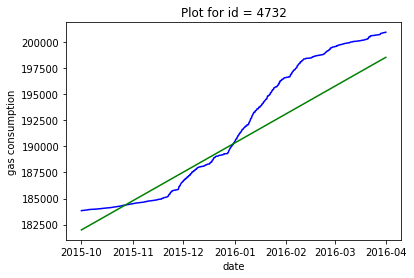

<Figure size 2160x2160 with 0 Axes>

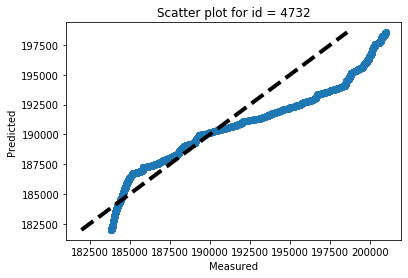

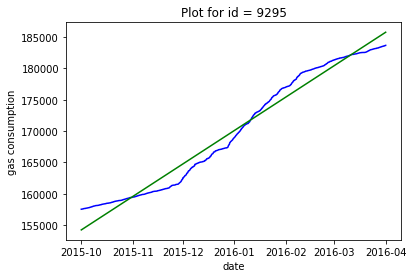

<Figure size 2160x2160 with 0 Axes>

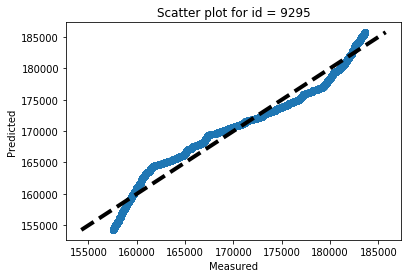

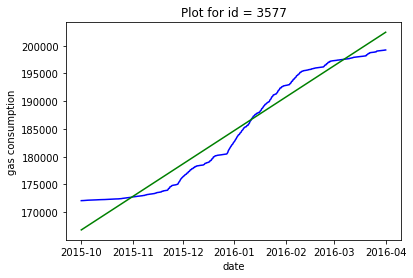

<Figure size 2160x2160 with 0 Axes>

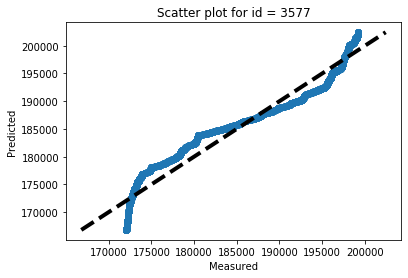

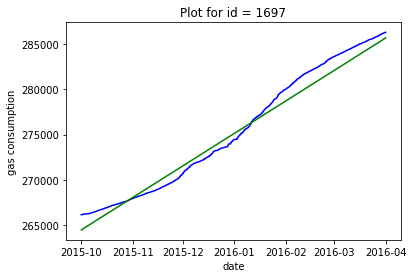

<Figure size 2160x2160 with 0 Axes>

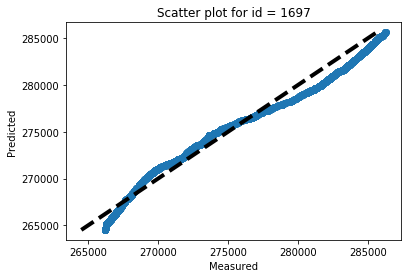

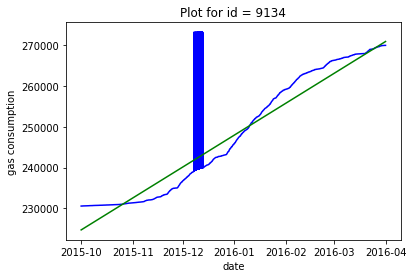

<Figure size 2160x2160 with 0 Axes>

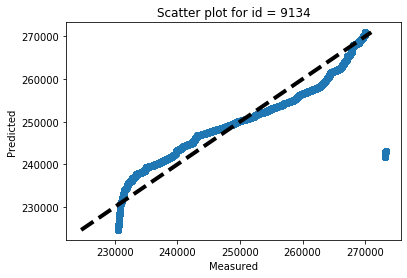

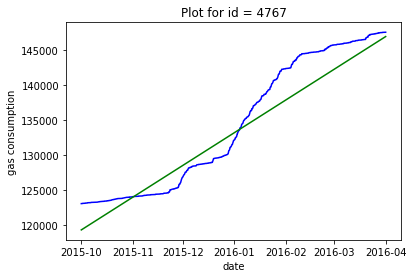

<Figure size 2160x2160 with 0 Axes>

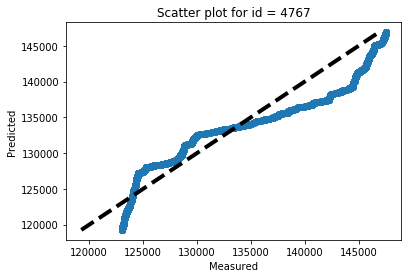

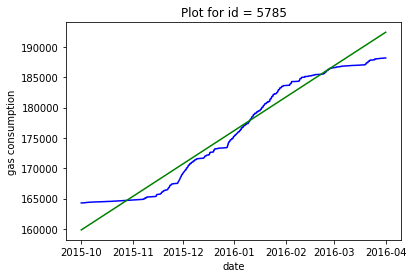

<Figure size 2160x2160 with 0 Axes>

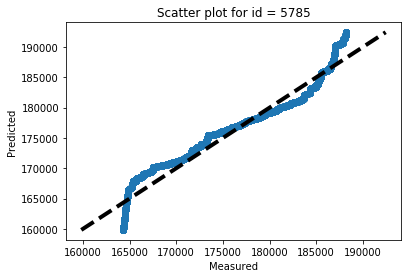

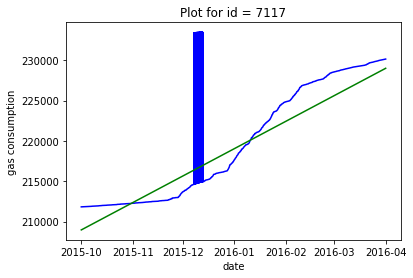

<Figure size 2160x2160 with 0 Axes>

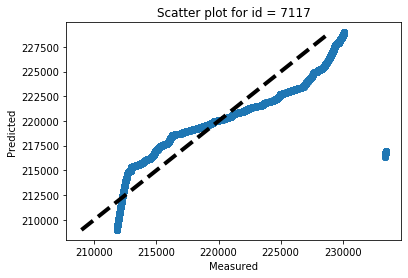

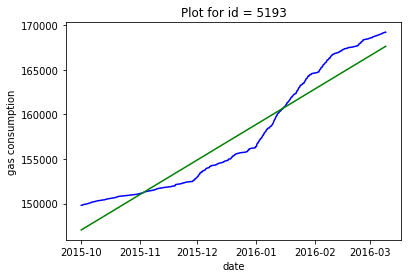

<Figure size 2160x2160 with 0 Axes>

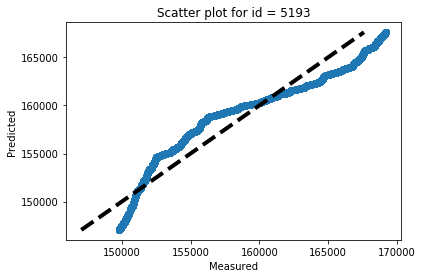

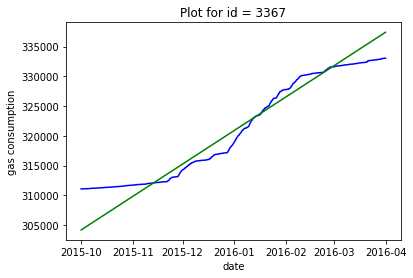

<Figure size 2160x2160 with 0 Axes>

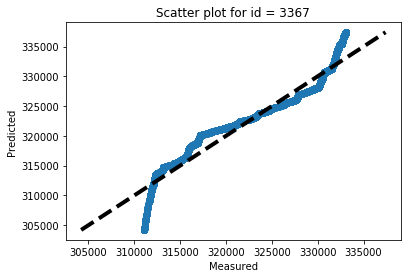

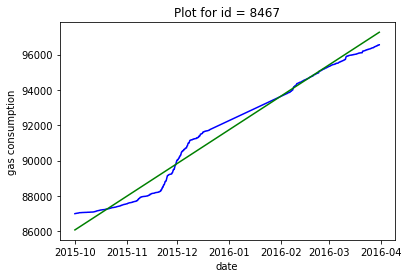

<Figure size 2160x2160 with 0 Axes>

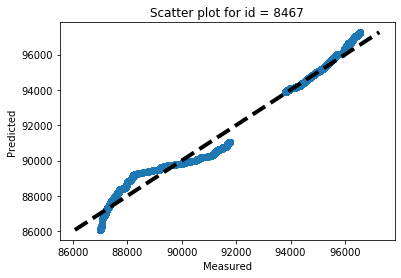

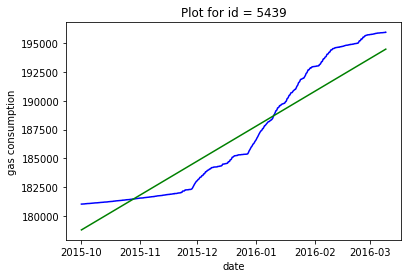

<Figure size 2160x2160 with 0 Axes>

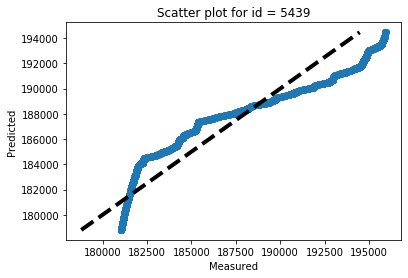

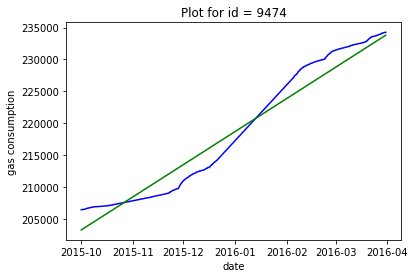

<Figure size 2160x2160 with 0 Axes>

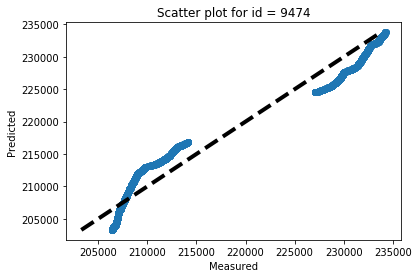

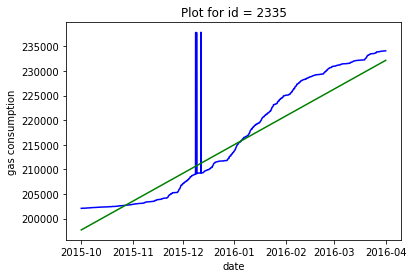

<Figure size 2160x2160 with 0 Axes>

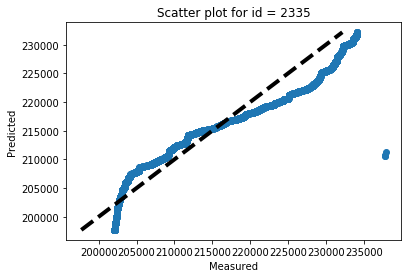

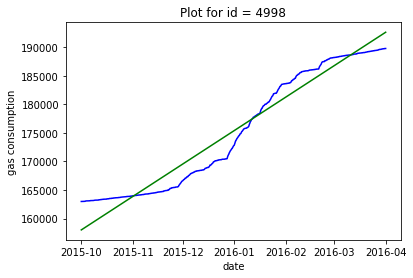

<Figure size 2160x2160 with 0 Axes>

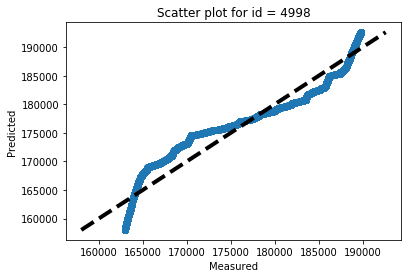

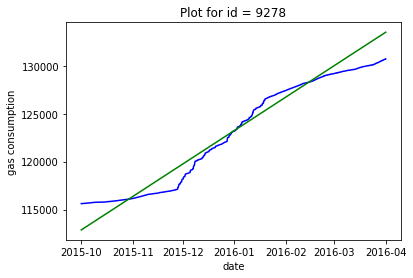

<Figure size 2160x2160 with 0 Axes>

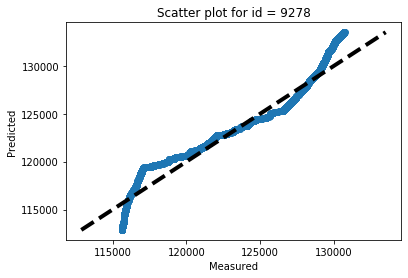

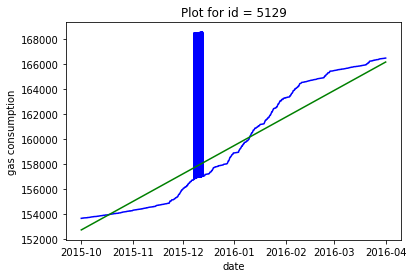

<Figure size 2160x2160 with 0 Axes>

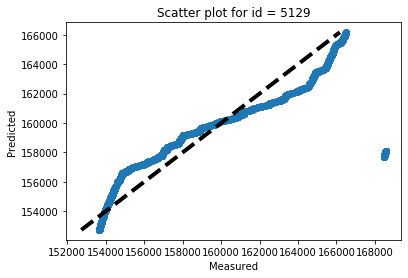

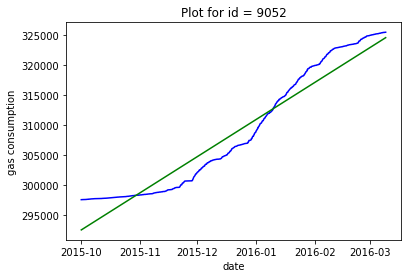

<Figure size 2160x2160 with 0 Axes>

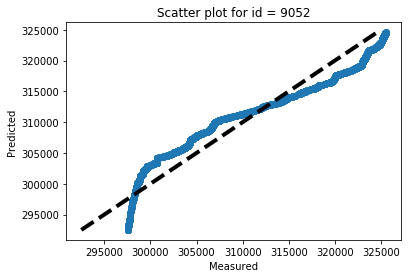

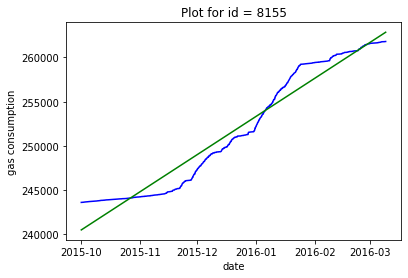

<Figure size 2160x2160 with 0 Axes>

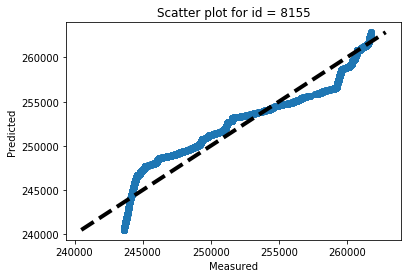

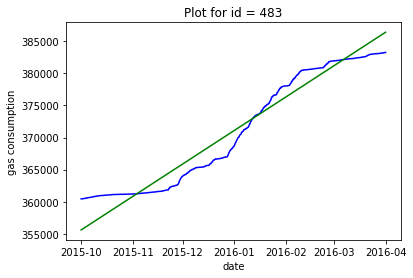

<Figure size 2160x2160 with 0 Axes>

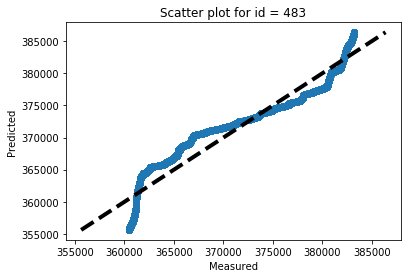

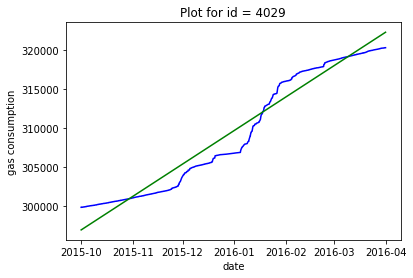

<Figure size 2160x2160 with 0 Axes>

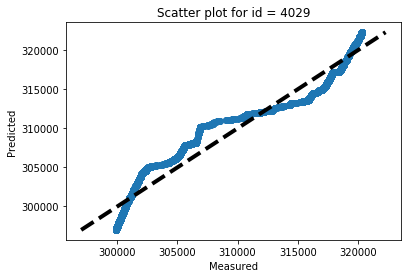

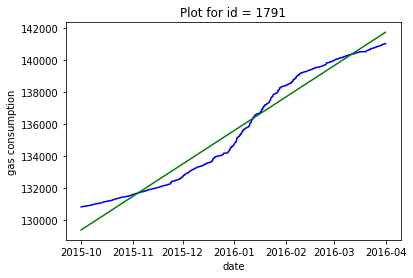

<Figure size 2160x2160 with 0 Axes>

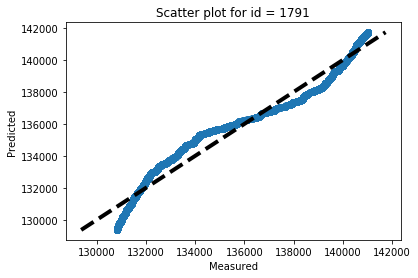

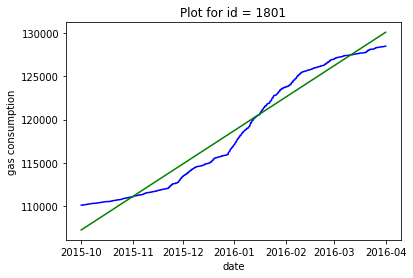

<Figure size 2160x2160 with 0 Axes>

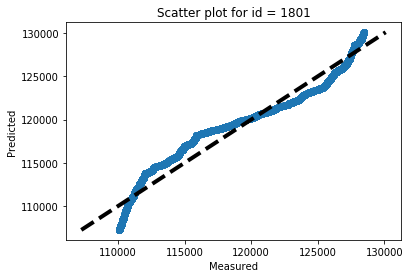

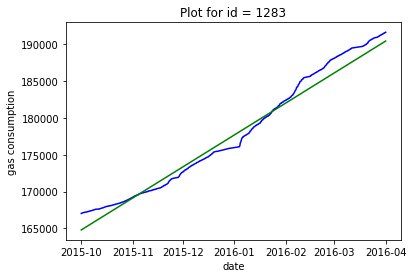

<Figure size 2160x2160 with 0 Axes>

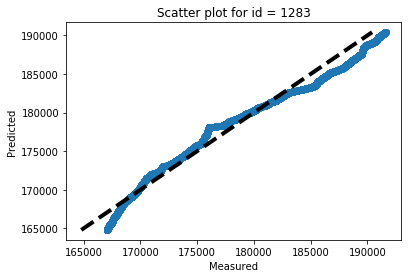

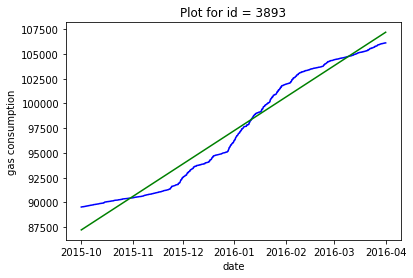

<Figure size 2160x2160 with 0 Axes>

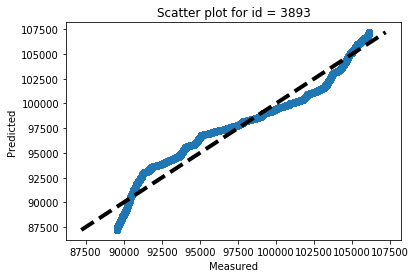

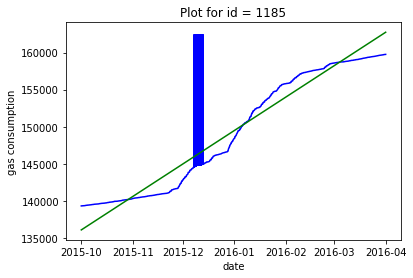

<Figure size 2160x2160 with 0 Axes>

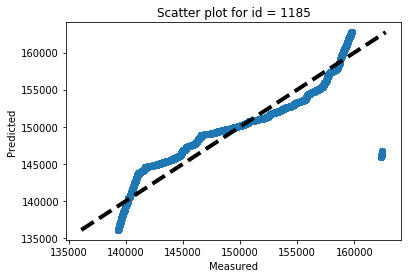

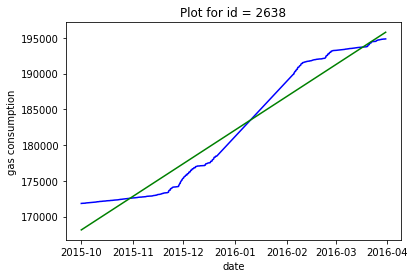

<Figure size 2160x2160 with 0 Axes>

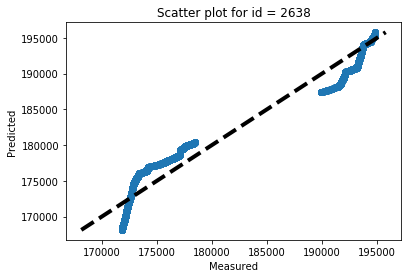

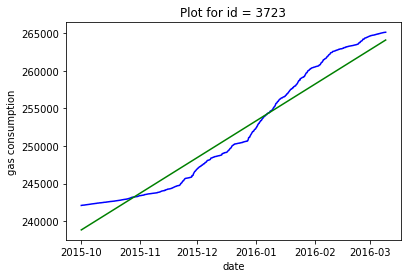

<Figure size 2160x2160 with 0 Axes>

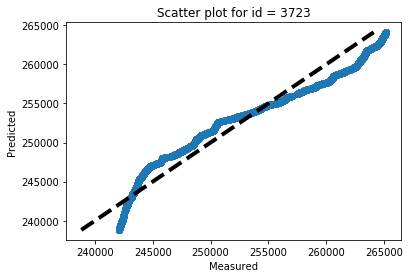

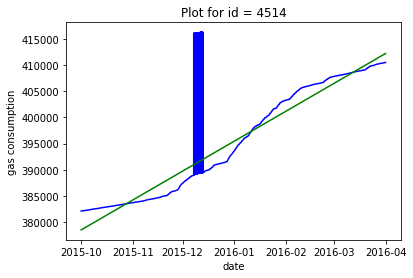

<Figure size 2160x2160 with 0 Axes>

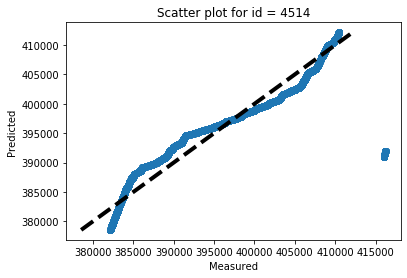

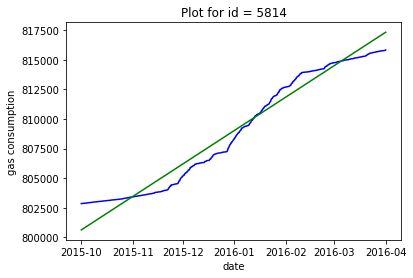

<Figure size 2160x2160 with 0 Axes>

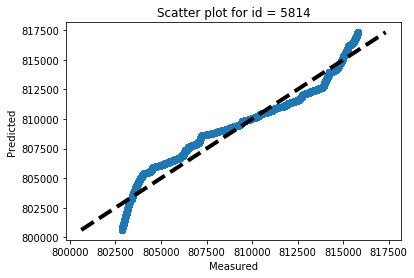

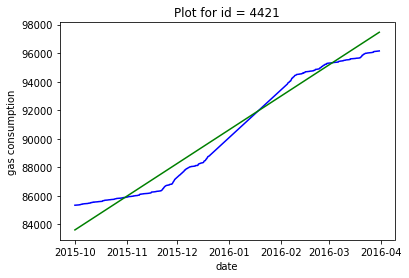

<Figure size 2160x2160 with 0 Axes>

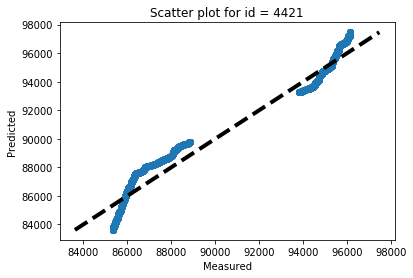

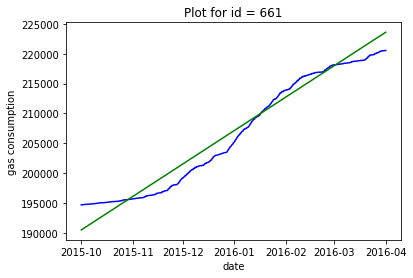

<Figure size 2160x2160 with 0 Axes>

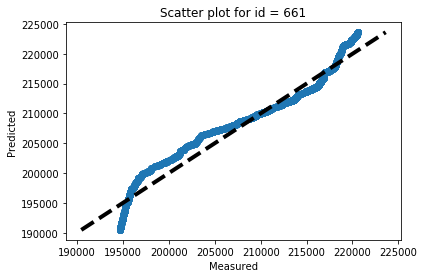

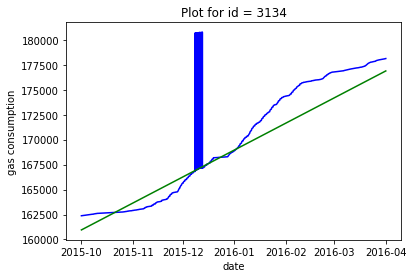

<Figure size 2160x2160 with 0 Axes>

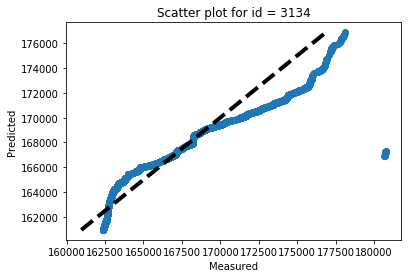

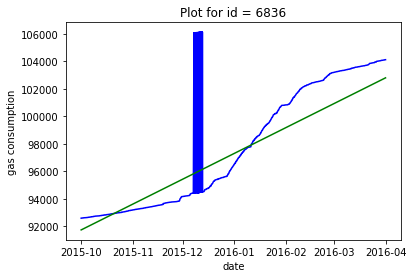

<Figure size 2160x2160 with 0 Axes>

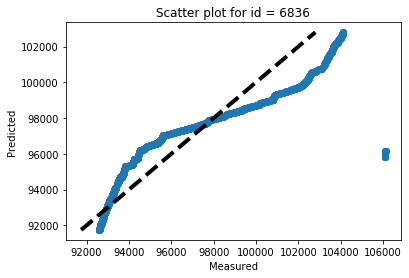

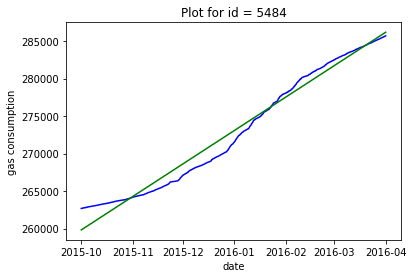

<Figure size 2160x2160 with 0 Axes>

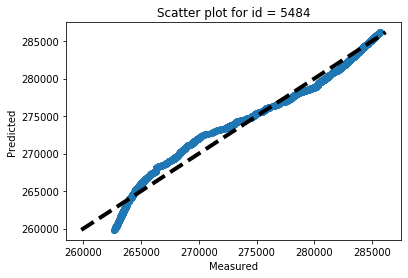

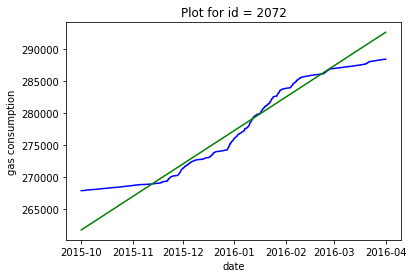

<Figure size 2160x2160 with 0 Axes>

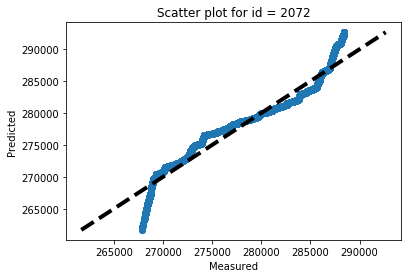

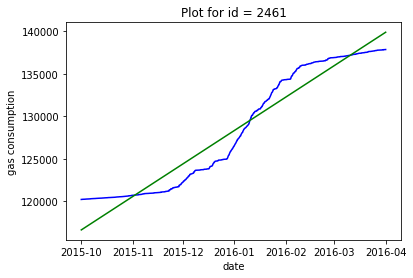

<Figure size 2160x2160 with 0 Axes>

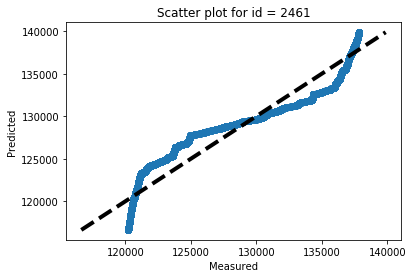

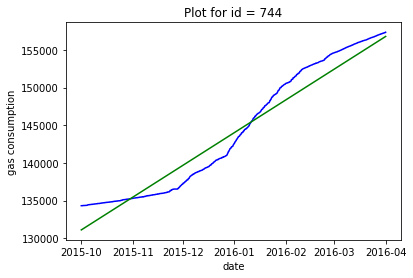

<Figure size 2160x2160 with 0 Axes>

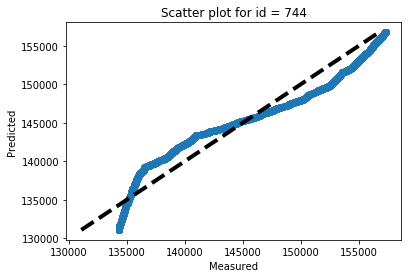

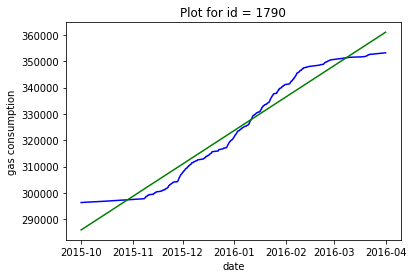

<Figure size 2160x2160 with 0 Axes>

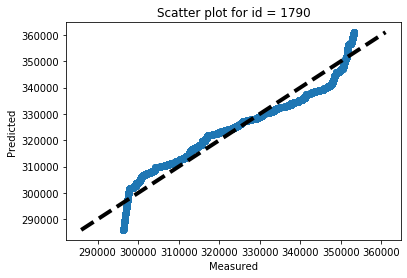

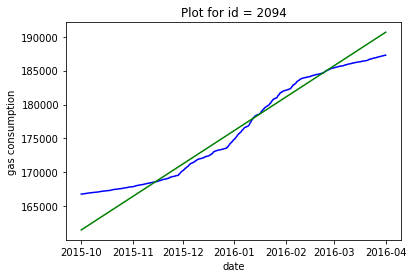

<Figure size 2160x2160 with 0 Axes>

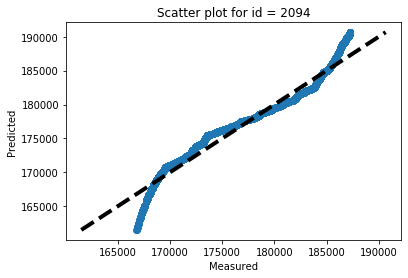

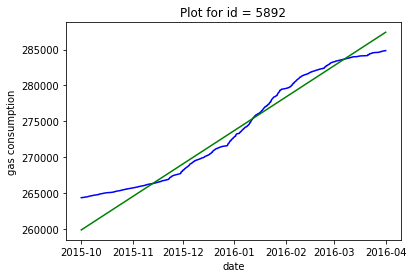

<Figure size 2160x2160 with 0 Axes>

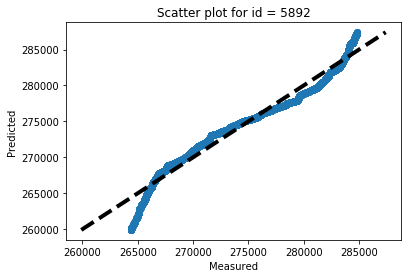

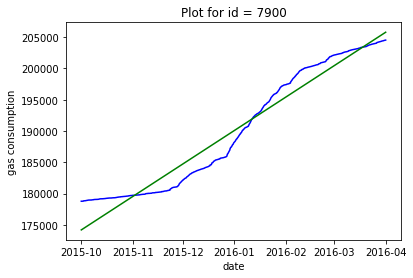

<Figure size 2160x2160 with 0 Axes>

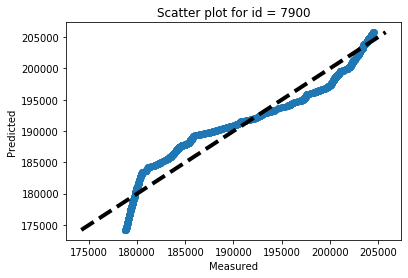

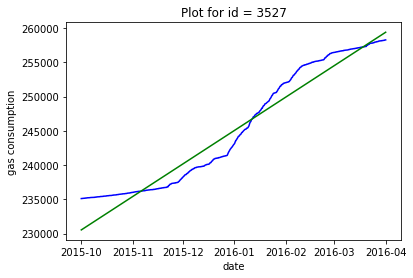

<Figure size 2160x2160 with 0 Axes>

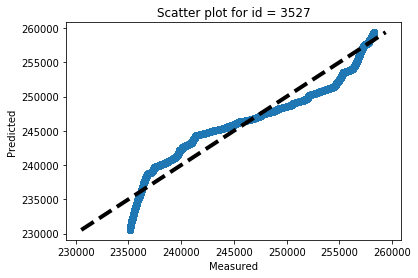

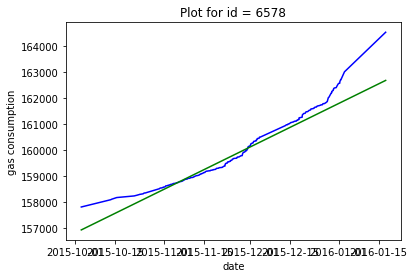

<Figure size 2160x2160 with 0 Axes>

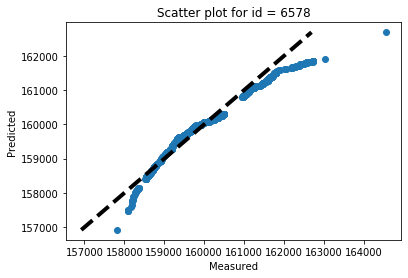

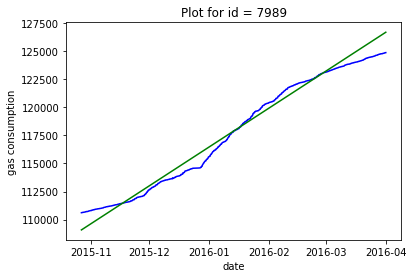

<Figure size 2160x2160 with 0 Axes>

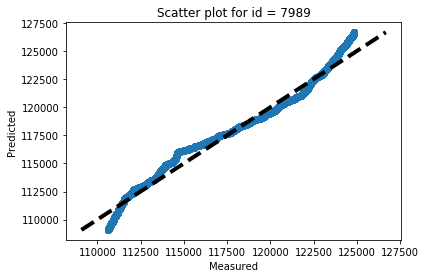

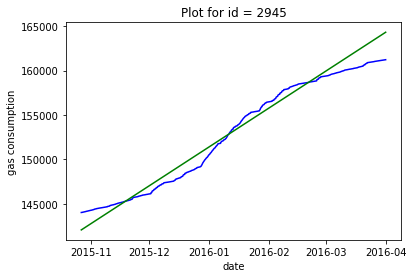

<Figure size 2160x2160 with 0 Axes>

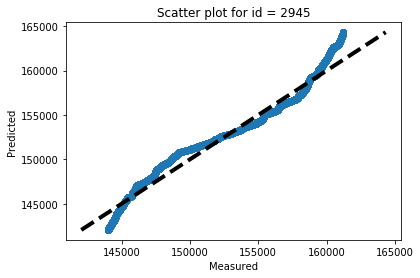

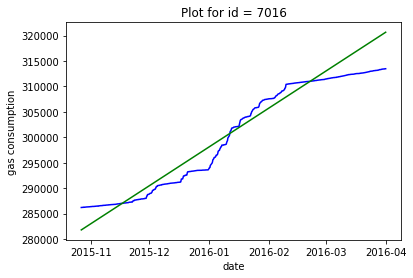

<Figure size 2160x2160 with 0 Axes>

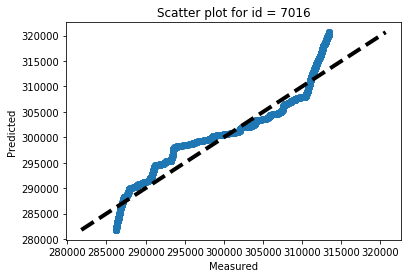

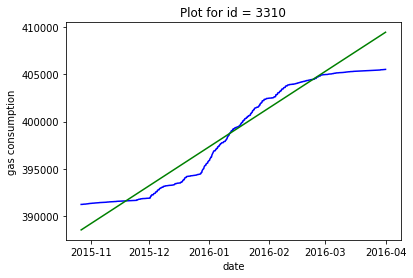

<Figure size 2160x2160 with 0 Axes>

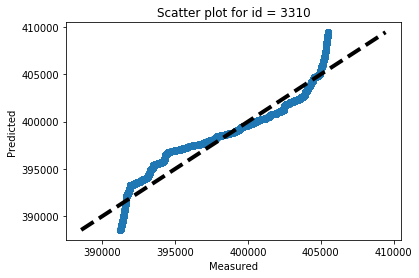

In [49]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

numplots = len(ids)
abs_sec_func = lambda td : td/np.timedelta64(1, 's')
vabs_sec = np.vectorize(abs_sec_func)
score = 0
n = 0
scores = defaultdict(int)

for dataid in ids:
    X_axis = list(df[df.id == dataid]['date'])
    #X = np.asarray([list(df[df.id == dataid]['year']),list(df[df.id == dataid]['month']),list(df[df.id == dataid]['day']),\
         #list(df[df.id == dataid]['hour']),list(df[df.id == dataid]['minute']),list(df[df.id == dataid]['second'])])
    date_deltas = df[df.id == dataid]['date'] - pd.to_datetime('2015-10-01 00:00:00')
    X = vabs_sec(date_deltas)
    Y = np.asarray(list(df[df.id == dataid]['measurement']))
    X_train, X_pred, Y_train, Y_act = data_split(X,Y,0.8) #Split the data into training and test set
    X_train = X_train.reshape(-1,1)
    X_pred = X_pred.reshape(-1,1)
    lm = LinearRegression()
    lm.fit(X_train,Y_train)
    Y_pred = lm.predict(X.reshape(-1,1))
    Y_eval = lm.predict(X_pred)
    score += r2_score(Y_act,Y_eval)
    n += 1
    scores[dataid] = r2_score(Y_act,Y_eval)
    plt.title('Plot for id = ' + str(dataid))
    plt.xlabel('date')
    plt.ylabel('gas consumption')
    plt.plot(X_axis,np.append(Y_train,Y_act),'b-') #Actual value
    plt.plot(X_axis,Y_pred, 'g') #predicted value
    plt.figure(figsize=(30,30))
    plt.show()
    
    fig, ax = plt.subplots()
    plt.title('Scatter plot for id = ' + str(dataid))
    ax.scatter(np.append(Y_train,Y_act),Y_pred)
    ax.plot([Y_pred.min(), Y_pred.max()], [Y_pred.min(), Y_pred.max()],'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()

r2_score for id : 8829 is -1.838161579864285
r2_score for id : 3723 is -4.432054787560756
r2_score for id : 661 is -1.5146189933119278


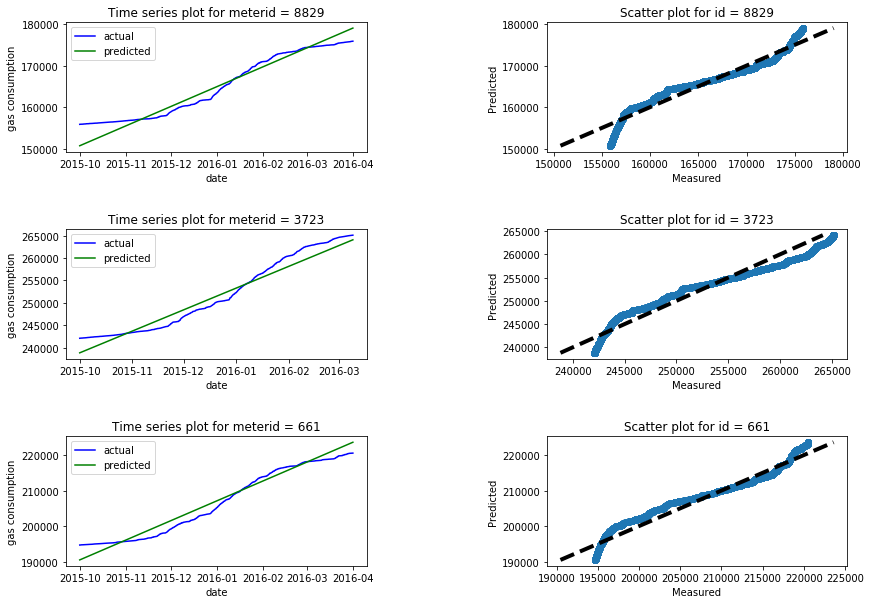

In [52]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(14,10)
fig.subplots_adjust(hspace=0.6, wspace=0.6)
for i in range(3): #Choose 3 candidate ids
    dataid = random.choice(ids)
    X_axis = list(df[df.id == dataid]['date'])
    date_deltas = df[df.id == dataid]['date'] - pd.to_datetime('2015-10-01 00:00:00')
    X = vabs_sec(date_deltas)
    Y = np.asarray(list(df[df.id == dataid]['measurement']))
    lm = LinearRegression()
    X_train, X_pred, Y_train, Y_act = data_split(X,Y,0.8)
    X_train = X_train.reshape(-1,1)
    X_pred = X_pred.reshape(-1,1)
    lm = LinearRegression()
    lm.fit(X_train,Y_train)
    Y_pred = lm.predict(X.reshape(-1,1))
    Y_eval = lm.predict(X_pred)
    Score = r2_score(Y_act,Y_eval)
    print("r2_score for id : " + str(dataid)+ " is " + str(Score))
    Y_pred = lm.predict(X.reshape(-1,1))
    axs[i, 0].plot(X_axis, Y,'b-', label = "actual") #Blue curve is the actual plot
    axs[i, 0].plot(X_axis, Y_pred, 'g-', label = "predicted")#Green curve is the predicted  plot
    axs[i, 0].legend()
    axs[i, 0].set_title('Time series plot for meterid = ' + str(dataid))
    axs[i, 0].set(xlabel='date', ylabel='gas consumption')
   
    
    axs[i, 1].scatter(Y,Y_pred)
    axs[i, 1].set_title('Scatter plot for id = ' + str(dataid))
    axs[i, 1].plot([Y_pred.min(), Y_pred.max()], [Y_pred.min(), Y_pred.max()],'k--', lw=4)
    axs[i, 1].set_xlabel('Measured')
    axs[i, 1].set_ylabel('Predicted')

In [53]:
#Evaluate the overall performance of the linear regression 
performance_score = score/n
print(str(performance_score))

-7.2274386634194805


In [54]:
sorted_scores = sorted(scores.items(), key=lambda kv: kv[1])
length = len(sorted_scores)

for i in range(5):
    print(str(i+1)+"    " + "meterid = " + str(sorted_scores[length-i-1][0]) + " with r^2 = " + str(sorted_scores[length-i-1][1]) )

1    meterid = 4447 with r^2 = 0.8263534169660388
2    meterid = 5484 with r^2 = 0.7726423954537807
3    meterid = 5810 with r^2 = 0.4958831374626059
4    meterid = 484 with r^2 = 0.4398377688988587
5    meterid = 7674 with r^2 = 0.23057363955509014


## 2.3 Forecasting using SVR 

In [55]:
#break = break
dfm = df_dropped.copy()
# dfm.head()

In [56]:
#Eliminate offset
for id in set(dfm.dataid):
    df = dfm.loc[dfm['dataid'] == id]
    offset = df.at[df.index[0], 'meter_value']
    for ind in df.index:
        dfm.at[ind,'meter_value'] -= offset

In [57]:
#Generating absolute seconds

x_time = dfm.localminute
x = []

i = 0
for e in x_time:
    month = int(e[5:7])
    day = int(e[8:10])
    hour = int(e[11:13])
    minute = int(e[14:16])
    sec = int(e[17:19])
    
    abs_sec = sec + 60*minute + 60*60*hour + 24*60*60*(day - 1)  
    if (month == 10):   
        abs_sec += 0
    elif (month == 11):
        abs_sec += 31*24*60*60
    elif (month == 12):
        abs_sec += (30+31)*24*60*60
    elif (month == 1):
        abs_sec += (31+30+31)*24*60*60
    elif (month == 2):
        abs_sec += (31+31+30+31)*24*60*60
    elif (month == 3):
        abs_sec += (29+31+31+30+31)*24*60*60
    
    x.append([abs_sec])   #[] needed for fitting svr but not for try daily function

In [58]:
len(x) == len(dfm)

True

In [59]:
dfm.insert(1, 'abs_sec', x, allow_duplicates = True)
dfm.head()

localminute abs_sec  dataid  meter_value
0  2015-10-01 00:00:10-05    [10]     739            0
1  2015-10-01 00:00:13-05    [13]    8890            0
2  2015-10-01 00:00:20-05    [20]    6910            0
3  2015-10-01 00:00:22-05    [22]    3635            0
4  2015-10-01 00:00:22-05    [22]    1507            0

### Predicting for one ID using a linear kernel

In [60]:
#Split into training and test set
import math
def splitting(x, y, train_frac):    
    n_samples = len(x)
    X_train = x[:math.floor(train_frac*n_samples)]
    X_pred = x[math.floor(train_frac*n_samples):]
    Y_train = y[:math.floor(train_frac*n_samples)]
    Y_ac = y[math.floor(train_frac*n_samples):]
    
    return X_train, X_pred, Y_train, Y_ac

In [61]:
#Generating 3 random IDs
amount = 3

import random
ids = random.sample(set(dfm.dataid), amount)
ids

[8386, 6578, 3036]

In [62]:
from sklearn.svm import SVR
from sklearn.svm import LinearSVR 
from sklearn.model_selection import GridSearchCV

In [63]:
svr = LinearSVR(C=1e3, epsilon=0, random_state=0, max_iter = 1e4)

The R^2 score of the forecasting for ID 8386 is: -4.141876374490473
The R^2 score of the forecasting for ID 6578 is: -1.7951280220604402
The R^2 score of the forecasting for ID 3036 is: 0.8368300612794092


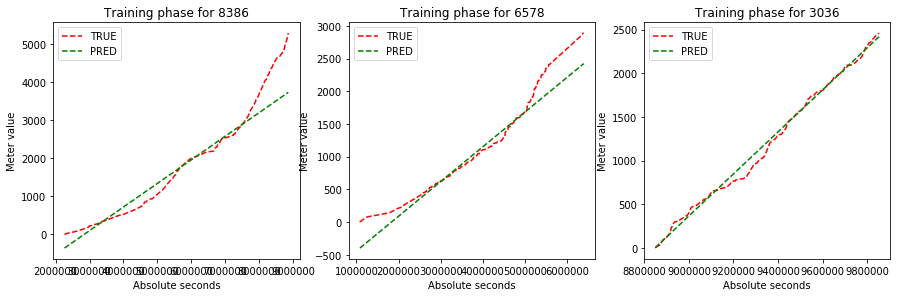

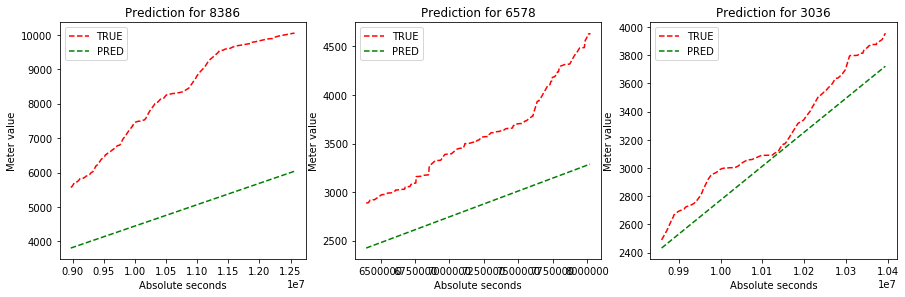

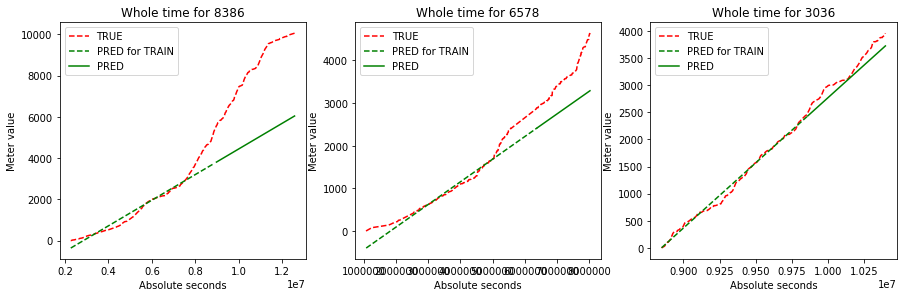

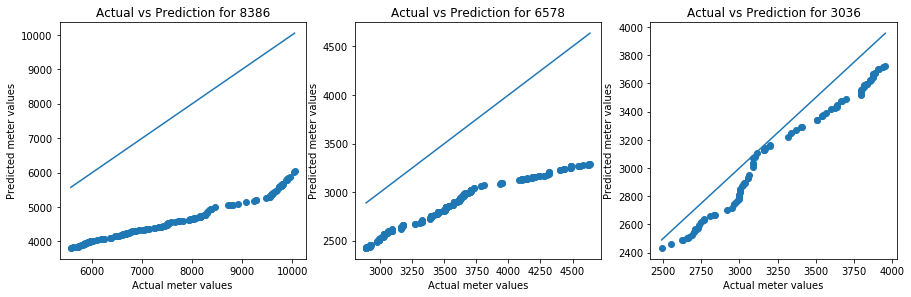

In [64]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()

train_plot = plt.figure(figsize=(15, 20))
prediction_plot = plt.figure(figsize=(15, 20))
t_p_plot = plt.figure(figsize=(15, 20))
vs_plot = plt.figure(figsize=(15, 20))

i = 0
for idd in ids:
    i += 1
    
    #Generating training and test set
    dfm_correct = dfm.loc[dfm['dataid'] == idd]
    x = dfm_correct.abs_sec.tolist()
    x_scaled = scaler.fit_transform(x)         #necessary, because otherwise no convergence
    y = dfm_correct.meter_value.tolist()
    X_train, X_pred, Y_train, Y_ac = splitting(x_scaled, y, 0.7)
    
    svr.fit(X_train, Y_train)
    
    X_train_unscaled, X_pred_unscaled, how, cares = splitting(x, y, 0.7)
    #Plot how well the models fit the training data
    tp_ax = train_plot.add_subplot(4, 3, i)
    tp_ax.plot(X_train_unscaled, Y_train, 'r--', label='TRUE')
    tp_ax.plot(X_train_unscaled, svr.predict(X_train), 'g--', label='PRED')
    tp_ax.set_xlabel('Absolute seconds')
    tp_ax.set_ylabel('Meter value')
    tp_ax.set_title('Training phase for {}'.format(idd))
    tp_ax.legend()
    
    #Plot the prediction
    pp_ax = prediction_plot.add_subplot(4, 3, i)
    pp_ax.plot(X_pred_unscaled, Y_ac, 'r--', label='TRUE')
    pp_ax.plot(X_pred_unscaled, svr.predict(X_pred), 'g--', label='PRED')
    pp_ax.set_xlabel('Absolute seconds')
    pp_ax.set_ylabel('Meter value')
    pp_ax.set_title('Prediction for {}'.format(idd))
    pp_ax.legend()
    
    #Plot traing + prediction
    tpp_ax = t_p_plot.add_subplot(4, 3, i)
    tpp_ax.plot(x, y, 'r--', label='TRUE')
    tpp_ax.plot(X_train_unscaled, svr.predict(X_train), 'g--', label='PRED for TRAIN')
    tpp_ax.plot(X_pred_unscaled, svr.predict(X_pred), 'g-', label='PRED')
    tpp_ax.set_xlabel('Absolute seconds')
    tpp_ax.set_ylabel('Meter value')
    tpp_ax.set_title('Whole time for {}'.format(idd))
    tpp_ax.legend()
    
    #Scatter actual vs predicted
    vs_ax = vs_plot.add_subplot(4, 3, i)
    vs_ax.scatter(Y_ac, svr.predict(X_pred))
    vs_ax.plot(Y_ac, Y_ac)
    vs_ax.set_xlabel('Actual meter values')
    vs_ax.set_ylabel('Predicted meter values')
    vs_ax.set_title('Actual vs Prediction for {}'.format(idd))
    #vs_ax.legend()
    
    r2_prediction = svr.score(X_pred, Y_ac)
    print('The R^2 score of the forecasting for ID {} is: {}'.format(idd, r2_prediction))


#train_plot.show()
#prediction_plot.show()
#t_p_plot.show()
#vs_plot.show()

### Predicting for one ID using a RBF kernel

Without scaling of data and gamma=scale

In [65]:
#Different SVR
svr = SVR(C=1e2, gamma='scale', epsilon=0, max_iter=1e5)

The R^2 score of the forecasting for ID 8386 is: -9.083134564270509
The R^2 score of the forecasting for ID 6578 is: -18.69679393290447
The R^2 score of the forecasting for ID 3036 is: -16.317748060489542


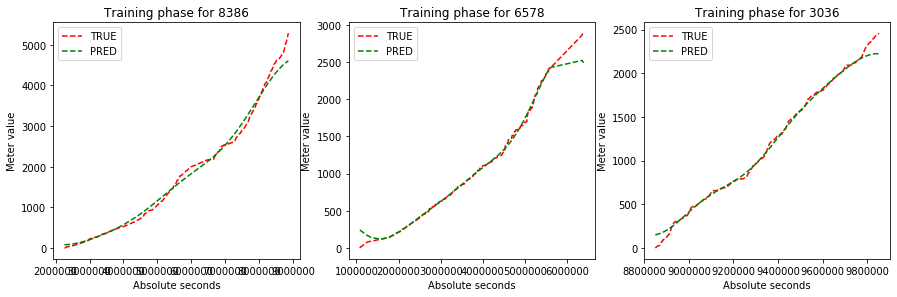

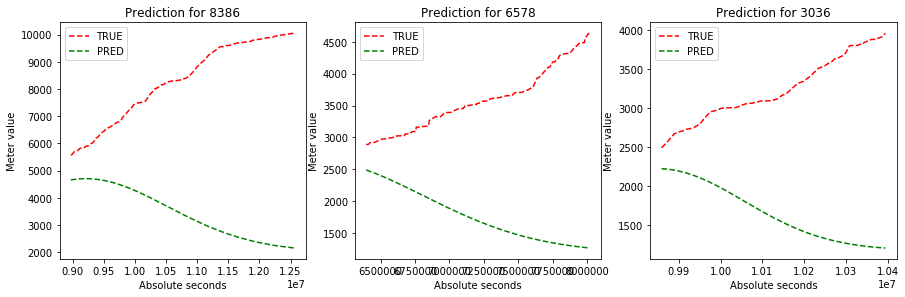

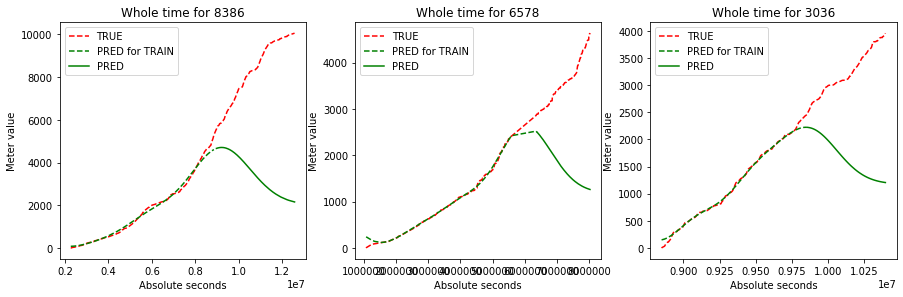

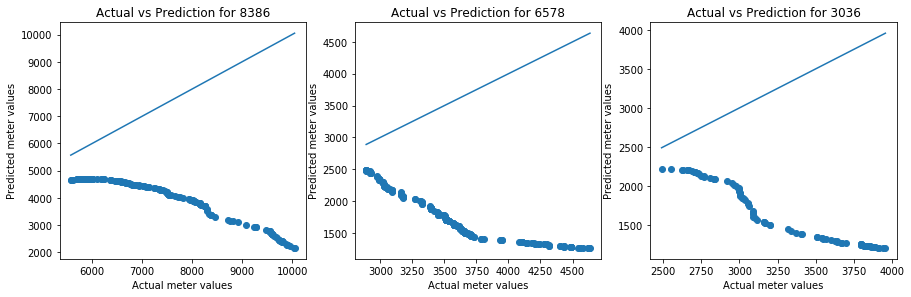

In [66]:
train_plot = plt.figure(figsize=(15, 20))
prediction_plot = plt.figure(figsize=(15, 20))
t_p_plot = plt.figure(figsize=(15, 20))
vs_plot = plt.figure(figsize=(15, 20))

i = 0
for idd in ids:
    i += 1
    
    #Generating training and test set
    dfm_correct = dfm.loc[dfm['dataid'] == idd]
    x = dfm_correct.abs_sec.tolist()
    y = dfm_correct.meter_value.tolist()
    X_train, X_pred, Y_train, Y_ac = splitting(x, y, 0.7)
    
    svr.fit(X_train, Y_train)
    
    #Plot how well the models fit the training data
    tp_ax = train_plot.add_subplot(4, 3, i)
    tp_ax.plot(X_train, Y_train, 'r--', label='TRUE')
    tp_ax.plot(X_train, svr.predict(X_train), 'g--', label='PRED')
    tp_ax.set_xlabel('Absolute seconds')
    tp_ax.set_ylabel('Meter value')
    tp_ax.set_title('Training phase for {}'.format(idd))
    tp_ax.legend()
    
    #Plot the prediction
    pp_ax = prediction_plot.add_subplot(4, 3, i)
    pp_ax.plot(X_pred, Y_ac, 'r--', label='TRUE')
    pp_ax.plot(X_pred, svr.predict(X_pred), 'g--', label='PRED')
    pp_ax.set_xlabel('Absolute seconds')
    pp_ax.set_ylabel('Meter value')
    pp_ax.set_title('Prediction for {}'.format(idd))
    pp_ax.legend()
    
    #Plot traing + prediction
    tpp_ax = t_p_plot.add_subplot(4, 3, i)
    tpp_ax.plot(x, y, 'r--', label='TRUE')
    tpp_ax.plot(X_train, svr.predict(X_train), 'g--', label='PRED for TRAIN')
    tpp_ax.plot(X_pred, svr.predict(X_pred), 'g-', label='PRED')
    tpp_ax.set_xlabel('Absolute seconds')
    tpp_ax.set_ylabel('Meter value')
    tpp_ax.set_title('Whole time for {}'.format(idd))
    tpp_ax.legend()
    
    #Scatter actual vs predicted
    vs_ax = vs_plot.add_subplot(4, 3, i)
    vs_ax.scatter(Y_ac, svr.predict(X_pred))
    vs_ax.plot(Y_ac, Y_ac)
    vs_ax.set_xlabel('Actual meter values')
    vs_ax.set_ylabel('Predicted meter values')
    vs_ax.set_title('Actual vs Prediction for {}'.format(idd))
    #vs_ax.legend()
    
    r2_prediction = svr.score(X_pred, Y_ac)
    print('The R^2 score of the forecasting for ID {} is: {}'.format(idd, r2_prediction))


#train_plot.show()
#prediction_plot.show()
#vs_plot.show()

With scaling of data using MinMaxScaler and using a fixed gamma

In [67]:
#trying wheter other kernels have better runtime when scaling data
#svr = SVR(kernel='linear', C=1e3, epsilon=0)
#svr = SVR(kernel='poly', C=1e3, epsilon=100, degree=4)
svr = SVR(kernel = 'rbf', C=1e4, gamma=2, max_iter=1e6)

The R^2 score of the forecasting for ID 8386 is: 0.9402321004170943
The R^2 score of the forecasting for ID 6578 is: -9.504806273173797
The R^2 score of the forecasting for ID 3036 is: -0.723103829890035


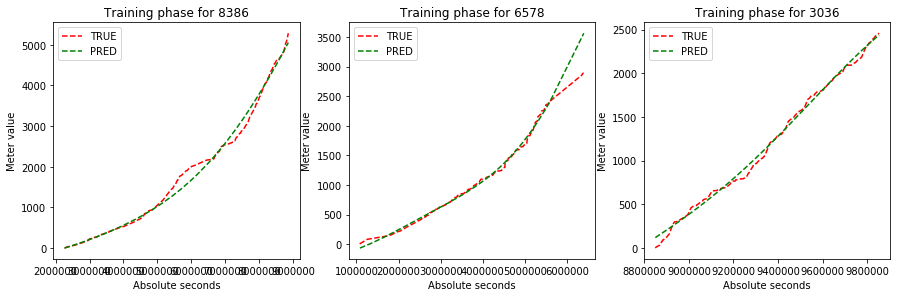

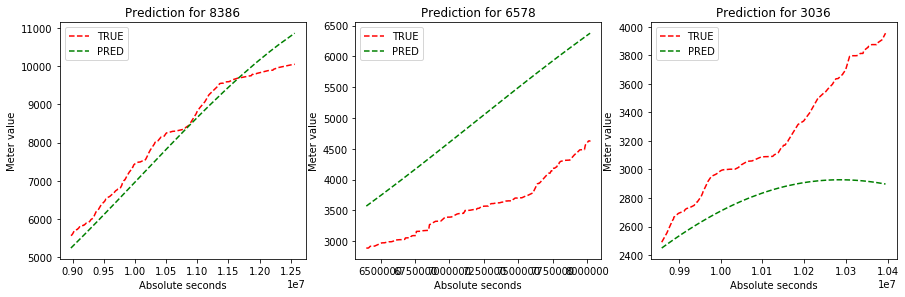

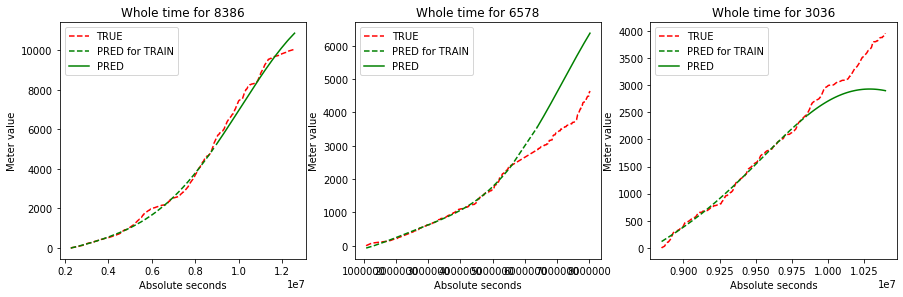

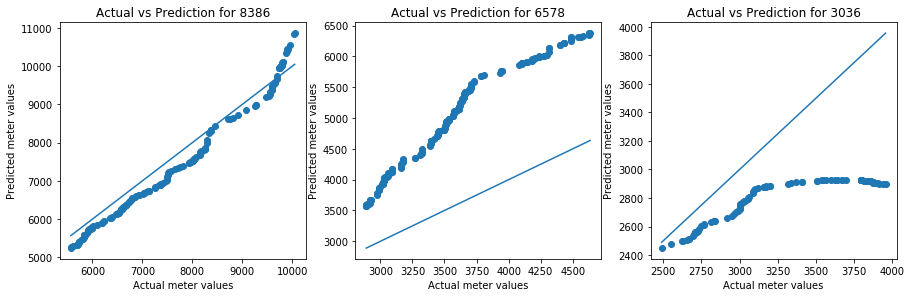

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()

train_plot = plt.figure(figsize=(15, 20))
prediction_plot = plt.figure(figsize=(15, 20))
t_p_plot = plt.figure(figsize=(15, 20))
vs_plot = plt.figure(figsize=(15, 20))

i = 0
for idd in ids:
    i += 1
    
    #Generating training and test set
    dfm_correct = dfm.loc[dfm['dataid'] == idd]
    x = dfm_correct.abs_sec.tolist()
    x_scaled = scaler.fit_transform(x)         #necessary, because otherwise no convergence
    y = dfm_correct.meter_value.tolist()
    X_train, X_pred, Y_train, Y_ac = splitting(x_scaled, y, 0.7)
    
    svr.fit(X_train, Y_train)
    
    X_train_unscaled, X_pred_unscaled, how, cares = splitting(x, y, 0.7)
    #Plot how well the models fit the training data
    tp_ax = train_plot.add_subplot(4, 3, i)
    tp_ax.plot(X_train_unscaled, Y_train, 'r--', label='TRUE')
    tp_ax.plot(X_train_unscaled, svr.predict(X_train), 'g--', label='PRED')
    tp_ax.set_xlabel('Absolute seconds')
    tp_ax.set_ylabel('Meter value')
    tp_ax.set_title('Training phase for {}'.format(idd))
    tp_ax.legend()
    
    #Plot the prediction
    pp_ax = prediction_plot.add_subplot(4, 3, i)
    pp_ax.plot(X_pred_unscaled, Y_ac, 'r--', label='TRUE')
    pp_ax.plot(X_pred_unscaled, svr.predict(X_pred), 'g--', label='PRED')
    pp_ax.set_xlabel('Absolute seconds')
    pp_ax.set_ylabel('Meter value')
    pp_ax.set_title('Prediction for {}'.format(idd))
    pp_ax.legend()
    
    #Plot traing + prediction
    tpp_ax = t_p_plot.add_subplot(4, 3, i)
    tpp_ax.plot(x, y, 'r--', label='TRUE')
    tpp_ax.plot(X_train_unscaled, svr.predict(X_train), 'g--', label='PRED for TRAIN')
    tpp_ax.plot(X_pred_unscaled, svr.predict(X_pred), 'g-', label='PRED')
    tpp_ax.set_xlabel('Absolute seconds')
    tpp_ax.set_ylabel('Meter value')
    tpp_ax.set_title('Whole time for {}'.format(idd))
    tpp_ax.legend()
    
    #Scatter actual vs predicted
    vs_ax = vs_plot.add_subplot(4, 3, i)
    vs_ax.scatter(Y_ac, svr.predict(X_pred))
    vs_ax.plot(Y_ac, Y_ac)
    vs_ax.set_xlabel('Actual meter values')
    vs_ax.set_ylabel('Predicted meter values')
    vs_ax.set_title('Actual vs Prediction for {}'.format(idd))
    #vs_ax.legend()
    
    r2_prediction = svr.score(X_pred, Y_ac)
    print('The R^2 score of the forecasting for ID {} is: {}'.format(idd, r2_prediction))


#train_plot.show()
#prediction_plot.show()
#vs_plot.show()

# 3. Student Proposal

In theproposal part, we carry out some additional analysis using the dataset given and weather information in Austin we found in https://www.kaggle.com/grubenm/austin-weather . 

We focus on two main aspects, one is predicting daily gas consumption and the other is using gas consumption to predict or find the correlation to weather information.

Two methods or models are used to implement the analysis, XgBoost (basing on machine learning algorithm random forest) and LSTM (basing on deep learning algorithm recurrent neural network).

### Data preprocessing

Generate daily gas consumption and load weather information. Taking average temperature (F), average humidity (%) and average visibility (mile) as additional features.

In [69]:
df_raw = df_dropped   #  ['localminute','dataid','meter_value']
data_id = list(set(df_raw['dataid']))
data_id = sorted(data_id)
data_id = [x for x in data_id if x not in late_id]  # remove late_id, 120 id remains
# len(data_id)

In [70]:
# generate daily readings
import datetime 
daily_reading = {}
shit_id = []
for i in data_id:
    daily_reading[i] = []
    subset = df_raw[df_raw['dataid']== i].values # np.array
    time = subset[:,0]
    for k in range(time.shape[0]):
        sub_time = time[k][:19]
        sub_time = datetime.datetime.strptime(sub_time, "%Y-%m-%d %H:%M:%S")
        time[k] = sub_time
    subset[:,0] = time
    
    for j in range(subset.shape[0]):
        if j == 0:
            baseline = time[0]
            baseline_reading = subset[0,2]
            continue
        now = subset[j,0]
        interval = (now - baseline).days
        if interval < 1:
            continue
        elif interval == 1:
            previous_reading = subset[j-1, 2]
            now_reading = subset[j, 2]
            consum = (now_reading + previous_reading)/2 - baseline_reading
#             print(f'{subset[j,0]}: {subset[j,2]} \t{subset[j-1,0]}: {subset[j-1,2]}')
            if consum <0:
                consum = 0
                shit_id.append(i)
#                 print('id:',i)
#                 print(now_reading)
#                 print(previous_reading)
            daily_reading[i].append(consum)
            baseline = baseline + datetime.timedelta(days=1)
            baseline_reading = consum + baseline_reading
        else:
            previous_reading = subset[j-1, 2]
            now_reading = subset[j, 2]
            bias = (now_reading - baseline_reading)/interval
            for m in range(interval):
                daily_reading[i].append(bias)
            baseline = baseline + datetime.timedelta(days = interval)
            baseline_reading = bias*interval + baseline_reading
# print(daily_reading)
shit_id = list(set(shit_id))
print(f"Due to too many outliers that making daily readings negative, \nseveral meters are dropped when generating the daily reading. They are:\n{shit_id}")

Due to too many outliers that making daily readings negative, 
several meters are dropped when generating the daily reading. They are:
[1185, 4514, 5129, 7117, 9134, 2449, 6836, 7030, 3544, 5403]


In [71]:
# Remove meters that had negative values in daily readings
length_list = []
new_id = []
for i in range(len(df_start)-len(late_id)):
    value_len = len(daily_reading[data_id[i]])
    if value_len >= 180:
        new_id.append(data_id[i])
# print(len(new_id))
new_id = [x for x in new_id if x not in shit_id]
print(f'Finally, we use {len(new_id)} meters in daily readings dataset.')     

Finally, we use 94 meters in daily readings dataset.


In [72]:
# sum up household readings corresponding to each day
comb_daily_reading = []
total_days = 180
for i in range(total_days):
    sum = 0
    for j in new_id:
        sum += daily_reading[j][i]
    comb_daily_reading.append(sum)
comb_daily_reading
print(f'\nThe daily gas consumption in the area ranges from {min(comb_daily_reading):.4f} to {max(comb_daily_reading):.4f}.')


The daily gas consumption in the area ranges from 2521.5417 to 36586.3075.


In [73]:
# normalization for gas consumption
global comb_daily_reading
comb_daily_reading = np.array(comb_daily_reading)
norm_comb_reading = (comb_daily_reading - min(comb_daily_reading))/(max(comb_daily_reading)-min(comb_daily_reading)) 


In [74]:
# Load weather dataset
df_austin_weather = pd.read_csv('austin_weather.csv')

for i in range(df_austin_weather.shape[0]):
    date = df_austin_weather.iloc[i][0]
    time = datetime.datetime.strptime(date, "%Y/%m/%d")
    df_austin_weather.replace(df_austin_weather.iloc[i][0], time, inplace = True)

df_austin_weather.head()

Date  TempHighF  TempAvgF  TempLowF DewPointHighF DewPointAvgF  \
0 2013-12-21         74        60        45            67           49   
1 2013-12-22         56        48        39            43           36   
2 2013-12-23         58        45        32            31           27   
3 2013-12-24         61        46        31            36           28   
4 2013-12-25         58        50        41            44           40   

  DewPointLowF HumidityHighPercent HumidityAvgPercent HumidityLowPercent  ...  \
0           43                  93                 75                 57  ...   
1           28                  93                 68                 43  ...   
2           23                  76                 52                 27  ...   
3           21                  89                 56                 22  ...   
4           36                  86                 71                 56  ...   

  SeaLevelPressureAvgInches SeaLevelPressureLowInches VisibilityHighMiles  \
0                     29.68                     29.59                  10   
1                     30.13                     29.87                  10   
2                     30.49                     30.41                  10   
3                     30.45                      30.3                  10   
4                     30.33                     30.27                  10   

  VisibilityAvgMiles VisibilityLowMiles WindHighMPH WindAvgMPH WindGustMPH  \
0                  7                  2          20          4          31   
1                 10                  5          16          6          25   
2                 10                 10           8          3          12   
3                 10                  7          12          4          20   
4                 10                  7          10          2          16   

  PrecipitationSumInches               Events  
0                   0.46  Rain , Thunderstorm  
1                      0                       
2                      0                       
3                      0                       
4                      T                       

[5 rows x 21 columns]

### 3.1 Using gas consumption to predict by XGBoost (Time interval = 1 day)

In [75]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [76]:
# timeline: 2015-10-2 to 2016-03-29
baseline_date = datetime.datetime.strptime('2015-10-2', "%Y-%m-%d")
end_date = datetime.datetime.strptime('2016-03-29', "%Y-%m-%d")
df_weather = df_austin_weather[(df_austin_weather['Date']>= baseline_date)&(df_austin_weather['Date']<= end_date)]

In [77]:
# split train set & validation set 
# first 150 timepoints to train and last 30 timepoints to validate (test)

# for gas consumption
train_set = norm_comb_reading[:150]
val_set = norm_comb_reading[150:]
x_train = train_set[:,np.newaxis]
x_val = val_set[:,np.newaxis]

# for weather information
labels = df_weather[['TempAvgF','HumidityAvgPercent','VisibilityAvgMiles']].values
y_train = labels[:150,:]
y_val = labels[150:,:]


#### 3.1.1 Predict Temperature

In [78]:
# xgboost
temLabel = y_train[:,0].tolist()
val_temLabel = y_val[:,0].tolist()
import xgboost as xgb
dtrain = xgb.DMatrix(x_train, label= temLabel)
dtest = xgb.DMatrix(x_val, label = val_temLabel)
param = {
    'objective': 'reg:linear',
    'max_depth': 5,
    'lambda': 0.3,
    'subsample': 0.8,
    'eta': 0.004,
    'alpha': 0.1,
    'seed': 1000,
    'nthread': 1,
    'eval_metric': 'mae'
}
# watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_rounds = 1000
plst = param.items()
bst = xgb.train(plst, dtrain, num_rounds)
yhat = bst.predict(dtest)

[12:06:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Training evaluation:
MSE: 15.315486703704519 MAE: 3.16729616800944
Test evaluation:
MSE: 70.7918481901123 MAE: 6.590348815917968


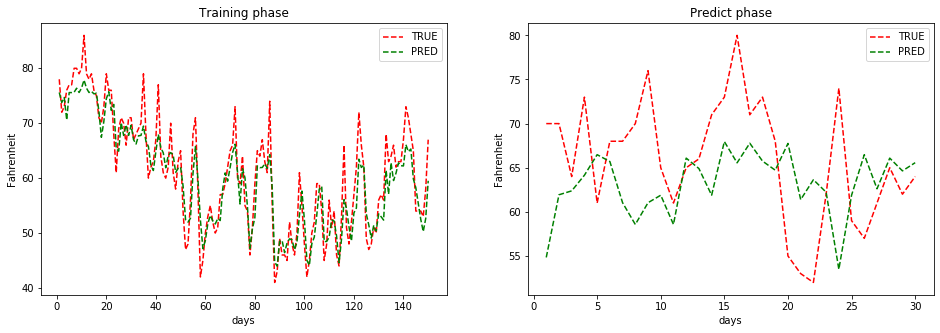

In [79]:
# plot training result and real gas consumption
x_pred = xgb.DMatrix(x_train)
y_train_pred = bst.predict(x_pred)
y1 = temLabel
y2 = y_train_pred.tolist()
# plot prediction temperature and ground truth temperature, 
x = []
for ii in range(150):
    ii += 1
    x.append(ii)
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax1.plot(x,y1,'r--',label='TRUE')
ax1.plot(x,y2,'g--',label='PRED')
plt.xlabel('days')
plt.ylabel('Fahrenheit')
plt.title('Training phase')
ax1.legend()

# plot test result and real visibility
y11 = val_temLabel
y22 = yhat.tolist()
x = []
for ii in range(30):
    ii += 1
    x.append(ii)
ax2 = fig.add_subplot(122)
ax2.plot(x,y11,'r--',label='TRUE')
ax2.plot(x,y22,'g--',label='PRED')
plt.xlabel('days')
plt.ylabel('Fahrenheit')
plt.title('Predict phase')
ax2.legend()

y1 = np.array(y1)
y2 = np.array(y2)
print('Training evaluation:')
print('MSE:',mean_squared_error(y1, y2),'MAE:',mean_absolute_error(y1, y2))
y1 = np.array(y11)
y2 = np.array(y22)
print('Test evaluation:')
print('MSE:',mean_squared_error(y1, y2),'MAE:',mean_absolute_error(y1, y2))

#### 3.1.2 Predict Humidity

In [80]:
humLabel = y_train[:,1].tolist()
val_humLabel = y_val[:,1].tolist()
humLabel = list(map(int, humLabel))
val_humLabel = list(map(int, val_humLabel))
import xgboost as xgb
dtrain = xgb.DMatrix(x_train, label= humLabel)
dtest = xgb.DMatrix(x_val, label = val_humLabel)
param = {
    'gamma': 0.2,
    'objective': 'reg:linear',
    'max_depth': 5,
    'lambda': 0.3,
    'subsample': 0.8,
    'eta': 0.004,
    'alpha': 0.1,
    'seed': 1000,
    'nthread': 1,
    'eval_metric': 'mae'
}
# watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_rounds = 1000
plst = param.items()
bst = xgb.train(plst, dtrain, num_rounds)
yhat = bst.predict(dtest)

[12:06:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Training evaluation:
MSE: 76.88657179413771 MAE: 7.02788579305013
Test evaluation:
MSE: 238.9479382287997 MAE: 12.709200668334962


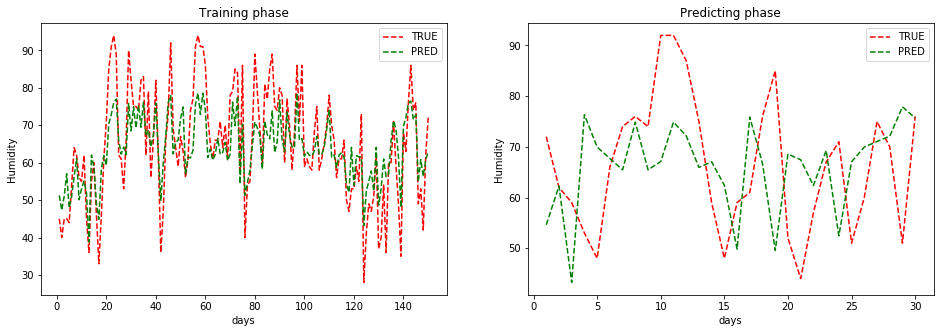

In [81]:
# plot training result and real gas consumption
x_pred = xgb.DMatrix(x_train)
y_train_pred = bst.predict(x_pred)
y1 = humLabel
y2 = y_train_pred.tolist()
# plot prediction temperature and ground truth temperature, 
x = []
for ii in range(150):
    ii += 1
    x.append(ii)
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax1.plot(x,y1,'r--',label='TRUE')
ax1.plot(x,y2,'g--',label='PRED')
plt.xlabel('days')
plt.ylabel('Humidity')
plt.title('Training phase')
ax1.legend()

# plot test result and real visibility
y11 = val_humLabel
y22 = yhat.tolist()
x = []
for ii in range(30):
    ii += 1
    x.append(ii)
ax2 = fig.add_subplot(122)
ax2.plot(x,y11,'r--',label='TRUE')
ax2.plot(x,y22,'g--',label='PRED')
plt.xlabel('days')
plt.ylabel('Humidity')
plt.title('Predicting phase')
ax2.legend()

y1 = np.array(y1)
y2 = np.array(y2)
print('Training evaluation:')
print('MSE:',mean_squared_error(y1, y2),'MAE:',mean_absolute_error(y1, y2))
y1 = np.array(y11)
y2 = np.array(y22)
print('Test evaluation:')
print('MSE:',mean_squared_error(y1, y2),'MAE:',mean_absolute_error(y1, y2))

#### 3.1.3 Predict Visibility

In [82]:
visLabel = y_train[:,2].tolist()
val_visLabel = y_val[:,2].tolist()
visLabel = list(map(int, visLabel))
val_visLabel = list(map(int, val_visLabel))
import xgboost as xgb
dtrain = xgb.DMatrix(x_train, label= visLabel)
dtest = xgb.DMatrix(x_val, label = val_visLabel)
param = {
#     'gamma': 0.4,
    'objective': 'reg:linear',
    'max_depth': 5,
    'lambda': 0.3,
    'subsample': 0.8,
    'eta': 0.003,
    'alpha': 0.1,
    'seed': 1000,
    'nthread': 1,
    'eval_metric': 'mae'
}
# watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_rounds = 1000
plst = param.items()
bst = xgb.train(plst, dtrain, num_rounds)
yhat = bst.predict(dtest)

[12:07:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Training evaluation:
MSE: 0.9109468918747371 MAE: 0.8539721488952636
Test evaluation:
MSE: 2.6335961439897195 MAE: 1.3707473754882813


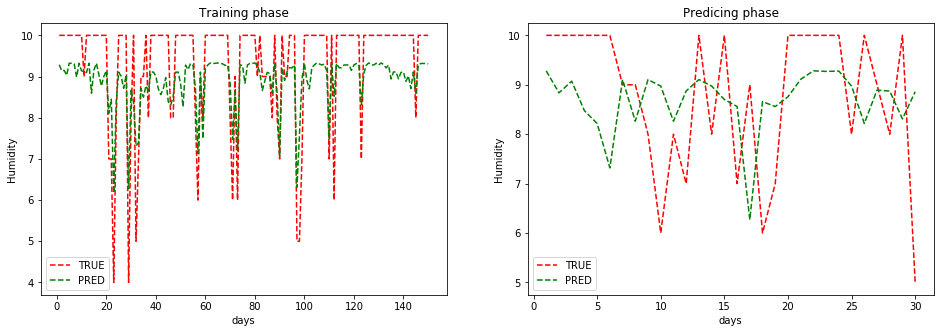

In [83]:
# plot training result and real gas consumption
x_pred = xgb.DMatrix(x_train)
y_train_pred = bst.predict(x_pred)
y1 = visLabel
y2 = y_train_pred.tolist()
# plot prediction temperature and ground truth temperature, 
x = []
for ii in range(150):
    ii += 1
    x.append(ii)
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax1.plot(x,y1,'r--',label='TRUE')
ax1.plot(x,y2,'g--',label='PRED')
plt.xlabel('days')
plt.title('Training phase')
plt.ylabel('Humidity')
ax1.legend()

# plot test result and real visibility
y11 = val_visLabel
y22 = yhat.tolist()
x = []
for ii in range(30):
    ii += 1
    x.append(ii)
ax2 = fig.add_subplot(122)
ax2.plot(x,y11,'r--',label='TRUE')
ax2.plot(x,y22,'g--',label='PRED')
plt.xlabel('days')
plt.ylabel('Humidity')
plt.title('Predicing phase')
ax2.legend()

y1 = np.array(y1)
y2 = np.array(y2)
print('Training evaluation:')
print('MSE:',mean_squared_error(y1, y2),'MAE:',mean_absolute_error(y1, y2))
y1 = np.array(y11)
y2 = np.array(y22)
print('Test evaluation:')
print('MSE:',mean_squared_error(y1, y2),'MAE:',mean_absolute_error(y1, y2))

#### 3.1.4 Predict gas consumption

In [84]:
gas_train = norm_comb_reading[:149][:,np.newaxis]
gas_pred = norm_comb_reading[1:150][:,np.newaxis]
gas_test = norm_comb_reading[150:179][:,np.newaxis]
gas_pred_test = norm_comb_reading[151:][:,np.newaxis]

In [85]:
dtrain = xgb.DMatrix(gas_train, label= gas_pred)
dtest = xgb.DMatrix(gas_test, label = gas_pred_test)
param = {
#     'gamma': 0.4,
    'objective': 'reg:linear',
    'max_depth': 5,
    'lambda': 0.2,
    'subsample': 0.8,
    'eta': 0.005,
    'alpha': 0.1,
    'seed': 1000,
    'nthread': 1,
    'eval_metric': 'mae'
}
# watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_rounds = 1000
plst = param.items()
bst = xgb.train(plst, dtrain, num_rounds)
yhat = bst.predict(dtest)

[12:07:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Training evaluation:
Normalized gas consumption MSE: 0.004715133153231344
Normalized gas consumption MAE: 0.04861761075477917
Gas consumption MSE: 5471479.522305487
Gas consumption MAE: 1656.1475274191396
Test evaluation:
Normalized gas consumption MSE: 0.007988629631138552
Normalized gas consumption MAE: 0.048058497254321736
Gas consumption MSE: 9270071.91898762
Gas consumption MAE: 1637.1014569324648


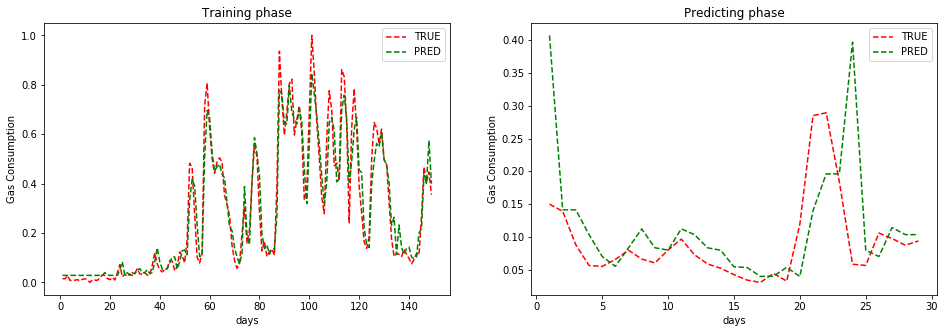

In [86]:
# plot training result and real gas consumption
x_pred = xgb.DMatrix(gas_train)
y_train_pred = bst.predict(x_pred)
y1 = gas_pred
y2 = y_train_pred.tolist()
# plot prediction temperature and ground truth temperature, 
x = []
for ii in range(149):
    ii += 1
    x.append(ii)
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax1.plot(x,y1,'r--',label='TRUE')
ax1.plot(x,y2,'g--',label='PRED')
plt.xlabel('days')
plt.ylabel('Gas Consumption')
plt.title('Training phase')
ax1.legend()

# plot test result and real visibility
y11 = gas_pred_test
y22 = yhat.tolist()
x = []
for ii in range(29):
    ii += 1
    x.append(ii)
ax2 = fig.add_subplot(122)
ax2.plot(x,y11,'r--',label='TRUE')
ax2.plot(x,y22,'g--',label='PRED')
plt.xlabel('days')
plt.ylabel('Gas Consumption')
plt.title('Predicting phase')
ax2.legend()

y1 = np.array(y1)
y2 = np.array(y2)
print('Training evaluation:')
print('Normalized gas consumption MSE:',mean_squared_error(y1, y2))
print('Normalized gas consumption MAE:',mean_absolute_error(y1, y2))
y1 = y1 * (max(comb_daily_reading)-min(comb_daily_reading)) + min(comb_daily_reading)
y2 = y2 * (max(comb_daily_reading)-min(comb_daily_reading)) + min(comb_daily_reading)
print('Gas consumption MSE:',mean_squared_error(y1, y2))
print('Gas consumption MAE:',mean_absolute_error(y1, y2))
y1 = np.array(y11)
y2 = np.array(y22)
print('Test evaluation:')
print('Normalized gas consumption MSE:',mean_squared_error(y1, y2))
print('Normalized gas consumption MAE:',mean_absolute_error(y1, y2))
y1 = y1 * (max(comb_daily_reading)-min(comb_daily_reading)) + min(comb_daily_reading)
y2 = y2 * (max(comb_daily_reading)-min(comb_daily_reading)) + min(comb_daily_reading)
print('Gas consumption MSE:',mean_squared_error(y1, y2))
print('Gas consumption MAE:',mean_absolute_error(y1, y2))

### 3.2 Using previous 5-day gas consumption to predict gas consumption by XGBoost

In [87]:
# training and test set generating
for i in range(145):
    if i == 0:
        sub_train = norm_comb_reading[:5][:,np.newaxis]
        sub_train = sub_train.reshape(1,-1)
        comb_train = sub_train 
    else:
        sub_train = norm_comb_reading[i:(i+5)][:,np.newaxis]
        sub_train = sub_train.reshape(1,-1)
        comb_train = np.concatenate((comb_train,sub_train))
gas_train = comb_train
gas_train_label = norm_comb_reading[5:150][:,np.newaxis]
for i in range(25):
    if i == 0:
        sub_train = norm_comb_reading[150:155][:,np.newaxis]
        sub_train = sub_train.reshape(1,-1)
        comb_train = sub_train 
    else:
        sub_train = norm_comb_reading[(i+150):(i+155)][:,np.newaxis]
        sub_train = sub_train.reshape(1,-1)
        comb_train = np.concatenate((comb_train,sub_train))
gas_pred = comb_train
gas_pred_label = norm_comb_reading[155:][:,np.newaxis]

In [88]:
dtrain = xgb.DMatrix(gas_train, label= gas_train_label)
dtest = xgb.DMatrix(gas_pred, label = gas_pred_label)
param = {
#     'gamma': 0.4,
    'objective': 'reg:linear',
    'max_depth': 5,
    'lambda': 0.2,
    'subsample': 0.8,
    'eta': 0.005,
    'alpha': 0.1,
    'seed': 1000,
    'nthread': 1,
    'eval_metric': 'mae'
}
# watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_rounds = 1000
plst = param.items()
bst = xgb.train(plst, dtrain, num_rounds)
yhat = bst.predict(dtest)

[12:07:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Training evaluation:
Normalized gas consumption MSE: 0.0013994388391170135
Normalized gas consumption MAE: 0.027427205133977457
Gas consumption MSE: 1623920.4073590706
Gas consumption MAE: 934.3013213003093
Test evaluation:
Normalized gas consumption MSE: 0.0048273057694173446
Normalized gas consumption MAE: 0.04242072619103445
Gas consumption MSE: 5601645.554203128
Gas consumption MAE: 1445.0521056446585


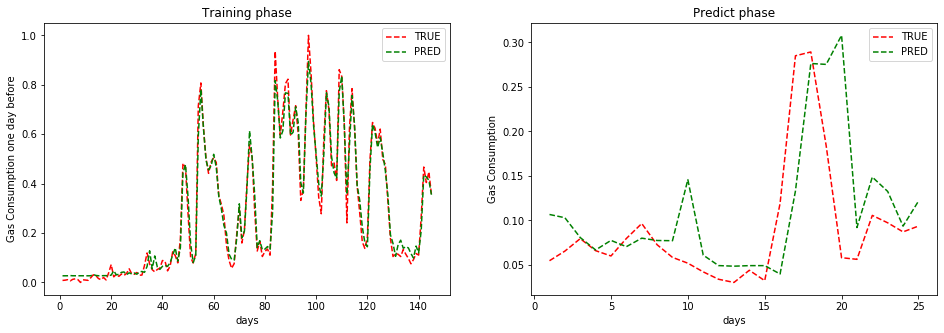

In [89]:
# plot training result and real gas consumption
x_pred = xgb.DMatrix(gas_train)
y_train_pred = bst.predict(x_pred)
y1 = gas_train_label
y2 = y_train_pred.tolist()
# plot prediction temperature and ground truth temperature, 
x = []
for ii in range(145):
    ii += 1
    x.append(ii)
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax1.plot(x,y1,'r--',label='TRUE')
ax1.plot(x,y2,'g--',label='PRED')
plt.xlabel('days')
plt.ylabel('Gas Consumption one day before')
plt.title('Training phase')
ax1.legend()

# plot test result and real visibility
y11 = gas_pred_label
y22 = yhat.tolist()
x = []
for ii in range(25):
    ii += 1
    x.append(ii)
ax2 = fig.add_subplot(122)
ax2.plot(x,y11,'r--',label='TRUE')
ax2.plot(x,y22,'g--',label='PRED')
plt.xlabel('days')
plt.ylabel('Gas Consumption')
plt.title('Predict phase')
ax2.legend()

y1 = np.array(y1)
y2 = np.array(y2)
print('Training evaluation:')
print('Normalized gas consumption MSE:',mean_squared_error(y1, y2))
print('Normalized gas consumption MAE:',mean_absolute_error(y1, y2))
y1 = y1 * (max(comb_daily_reading)-min(comb_daily_reading)) + min(comb_daily_reading)
y2 = y2 * (max(comb_daily_reading)-min(comb_daily_reading)) + min(comb_daily_reading)
print('Gas consumption MSE:',mean_squared_error(y1, y2))
print('Gas consumption MAE:',mean_absolute_error(y1, y2))
y1 = np.array(y11)
y2 = np.array(y22)
print('Test evaluation:')
print('Normalized gas consumption MSE:',mean_squared_error(y1, y2))
print('Normalized gas consumption MAE:',mean_absolute_error(y1, y2))
y1 = y1 * (max(comb_daily_reading)-min(comb_daily_reading)) + min(comb_daily_reading)
y2 = y2 * (max(comb_daily_reading)-min(comb_daily_reading)) + min(comb_daily_reading)
print('Gas consumption MSE:',mean_squared_error(y1, y2))
print('Gas consumption MAE:',mean_absolute_error(y1, y2))

### 3.3 Using previous 5 days gas consumption to make different predictions by LSTM

In [1]:
import torch
import torch.autograd as autograd 
from torch.autograd import Variable
import torch.nn as nn            
import torch.nn.functional as F   
import torch.optim as optim       
import torch.optim.lr_scheduler as lr_sch
from sklearn.metrics import mean_squared_error,mean_absolute_error
torch.manual_seed(1)

In [2]:
# Create a LSTM framework inherited from nn.Module in PyTorch.
"""
    Regression in LSTM

    Parameters:
    - input_size: feature size
    - hidde_size: number of hidden units
    - output_size: number of output
    - num_layers: layers of LSTM to stack
"""
class LSTM_single(nn.Module):
     def __init__(self, input_size, hidden_size=10, output_size=1, num_layers=1):
        super().__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
     def forward(self, _x):
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s * b, h)
        x = self.fc(x)
        x = x.view(s, b, -1) 
        return x


In [3]:
# Generate dataset for forecast basing on previous several days
def create_sequence(data, days_for_train, days_to_predict):
    data_x, data_y = [], []
    for i in range(int((len(data)-days_for_train) / days_to_predict)):
        _x = data[i : i + days_for_train]
        _y = data[i + days_for_train : i + days_for_train + days_to_predict]
        data_x.append(_x)
        data_y.append(_y)
    return (np.array(data_x), np.array(data_y))

In [4]:
def train(model, x_train, y_train, epoch):
    model.train()
    for i in range(epoch):
        optimizer.zero_grad()
        out = model(x_train) #(140,1,1)
        loss = loss_function(out, y_train)
        
        loss.backward()
        optimizer.step()
        if i >= 200:
            scheduler.step(loss)
        if (i+1) % 500 == 0:
            print(f'Train Epoch: {i+1}, Loss:{loss.item():.5f}')

In [5]:
def evaluation(x_val, mode='single'):
    model.eval()
    if mode=='single':
        y_pred = model(x_val)
        return y_pred.view(-1).detach().numpy()
    else:
        x, (h0,c0) = x_val
        y_pred = model(x, (h0,c0))
        y_pred = y_pred[:,0,:].reshape(x.shape[0],1,-1)
        return y_pred.view(-1).detach().numpy()

In [6]:
def perform(partition,pred,real):
    mse = mean_squared_error(pred, real)
    mae = mean_absolute_error(pred, real)
    print(f'\nEvaluate model in {partition} set:')
    print(f'The normalized MSE is: {mse}')
    print(f'The normalized MAE is: {mae}')
    delta = int(max(comb_daily_reading)-min(comb_daily_reading))
    pred_r = pred * delta + min(comb_daily_reading)
    real_r = real * delta + min(comb_daily_reading)
    mse_r = mean_squared_error(pred_r, real_r)
    mae_r = mean_absolute_error(pred_r, real_r)
    print(f'The real MSE is: {mse_r}')
    print(f'The real MAE is: {mae_r}')

#### 3.3.1 Predict gas consumption 

In [7]:
# LSTM: Use previous 5 days gas consumption to predict gas consumption for the next day.
DAYS_FOR_TRAIN = 5
DAYS_TO_PREDICT = 1
EPOCH = 1000
dataset = norm_comb_reading # Take normalized daily gas consumption as dataset
x_gas, y_gas = create_sequence(dataset, DAYS_FOR_TRAIN, DAYS_TO_PREDICT)

train_size = int(len(x_gas)*0.8)
x_gas_train = x_gas[:train_size]
y_gas_train = y_gas[:train_size]
x_gas_val = x_gas[train_size:]
y_gas_val = y_gas[train_size:]

x_gas_train = torch.Tensor(x_gas_train.reshape(-1,1,DAYS_FOR_TRAIN))
x_gas_val = torch.Tensor(x_gas_val.reshape(-1,1,DAYS_FOR_TRAIN))

# Start train and make evaluation for prediction result
model = LSTM_single(DAYS_FOR_TRAIN, output_size=DAYS_TO_PREDICT)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = lr_sch.ReduceLROnPlateau(optimizer, 'min', patience=50, threshold=1e-2)

train(model, x_gas_train, torch.Tensor(y_gas_train.reshape(-1,1,DAYS_TO_PREDICT)), EPOCH)

perform('training', evaluation(x_gas_train), y_gas_train)
perform('validation', evaluation(x_gas_val), y_gas_val)


NameError: name 'norm_comb_reading' is not defined

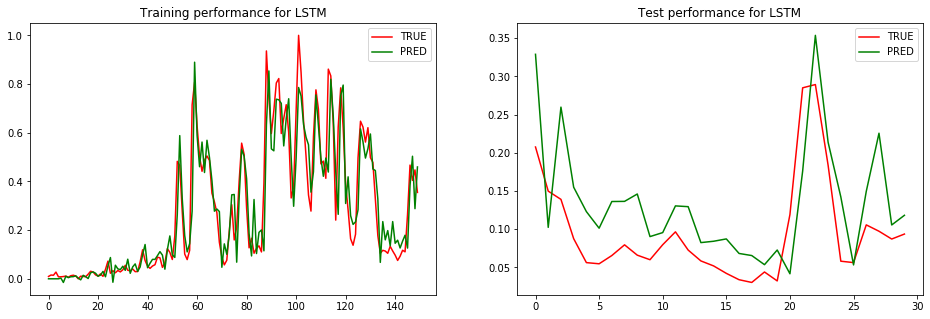

In [97]:
# Plot the train and prediction result
pred_gas = evaluation(torch.Tensor(x_gas.reshape(-1,1,DAYS_FOR_TRAIN)))
pred_gas = np.concatenate((np.zeros(DAYS_FOR_TRAIN), pred_gas))

fig, axes = plt.subplots(1, 2, figsize = (16, 5))
plt.subplot(121, title='Training performance for LSTM')
plt.plot(dataset[:150], 'r', label='TRUE')
plt.plot(pred_gas[:150], 'g', label='PRED')
plt.legend(loc='best')

plt.subplot(122, title='Test performance for LSTM')
plt.plot(dataset[150:], 'r', label='TRUE')
plt.plot(pred_gas[150:], 'g', label='PRED')
plt.legend(loc='best')
plt.show()

#### 3.3.2 Predict Temperature, Humidity and Visibility

In [98]:
# Get weather data
baseline_date = datetime.datetime.strptime('2015-10-2', "%Y-%m-%d")
end_date = datetime.datetime.strptime('2016-03-29', "%Y-%m-%d")
df_weather = df_austin_weather[(df_austin_weather['Date']>= baseline_date)&(df_austin_weather['Date']<= end_date)]

name = ['TempAvgF','HumidityAvgPercent','VisibilityAvgMiles']
labels = df_weather[name].values
labels_n = np.empty((180,3))
for i in range(len(name)):
    if isinstance(labels[0,i], str):
        labels[:,i] = [eval(labels[:,i][j]) for j in range(len(labels[:,i]))]
    # normalize
    labels_n[:,i] = (labels[:,i]-min(labels[:,i]))/(max(labels[:,i])-min(labels[:,i]))
    
# Take gas consumption as x, weather information as y
# x_train = norm_comb_reading[:150]
# x_val = norm_comb_reading[150:]

x_train = x_gas[:150]
x_val = x_gas[150:]
y_train = labels_n[5:155,:]
y_val = labels_n[155:,:]

In [99]:
# LSTM
train_epoch = 2000
# Initialize a two dimension array to save prediction results
pred = np.empty((len(labels)-5,3))
for i in range(labels.shape[1]):
    print(f'\nPredict {name[i]}:')

    # Initialize for each prediction
    model = LSTM_single(5, hidden_size=8, output_size=1, num_layers=1)
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    scheduler = lr_sch.ReduceLROnPlateau(optimizer, 'min', patience=50, threshold=1e-2)
    
    x_t = x_train.reshape(-1,1,5)
    x_v = x_val.reshape(-1,1,5)
    y_t = y_train[:,i].astype('float32').reshape(-1,1,1)
    y_v = y_val[:,i].astype('float32')
    train(model, torch.Tensor(x_t), torch.Tensor(y_t), train_epoch)
    pred[:,i] = evaluation(torch.Tensor(x_gas).reshape(-1,1,5))


Predict TempAvgF:
Train Epoch: 500, Loss:0.02069
Train Epoch: 1000, Loss:0.01741
Train Epoch: 1500, Loss:0.01741
Train Epoch: 2000, Loss:0.01741

Predict HumidityAvgPercent:
Train Epoch: 500, Loss:0.01977
Train Epoch: 1000, Loss:0.00980
Train Epoch: 1500, Loss:0.00918
Train Epoch: 2000, Loss:0.00918

Predict VisibilityAvgMiles:
Train Epoch: 500, Loss:0.02527
Train Epoch: 1000, Loss:0.00605
Train Epoch: 1500, Loss:0.00354
Train Epoch: 2000, Loss:0.00146


In [100]:
# check the MSE and MAE
for i in range(labels.shape[1]):
    delta = max(labels[:,i])-min(labels[:,i])
    pred_real = delta*pred[:,i] + min(labels[:,i])
    print(f'\n{name[i]}:')
    print("Evaluate model in training set:")    
    print(f"The normalized MSE is: {mean_squared_error(pred[:150,i], y_train[:,i])}")
    print(f"The normalized MAE is: {mean_absolute_error(pred[:150,i], y_train[:,i])}")
    print(f"The real MSE is: {mean_squared_error(pred_real[:150], labels[5:155,i])}")
    print(f"The real MAE is: {mean_absolute_error(pred_real[:150], labels[5:155,i])}")
    
    print("Evaluate model in validation set:")
    print(f"The normalized MSE is: {mean_squared_error(pred[150:,i], y_val[:,i])}")
    print(f"The normalized MAE is: {mean_absolute_error(pred[150:,i], y_val[:,i])}")
    print(f"The real MSE is: {mean_squared_error(pred_real[150:], labels[155:,i])}")
    print(f"The real MAE is: {mean_absolute_error(pred_real[150:], labels[155:,i])}")



TempAvgF:
Evaluate model in training set:
The normalized MSE is: 0.017408633660892733
The normalized MAE is: 0.09828966588664938
The real MSE is: 35.25248316330778
The real MAE is: 4.423034964899222
Evaluate model in validation set:
The normalized MSE is: 0.06038535332769784
The normalized MAE is: 0.20610141155454847
The real MSE is: 122.28034048858812
The real MAE is: 9.27456351995468

HumidityAvgPercent:
Evaluate model in training set:
The normalized MSE is: 0.009177504736709174
The normalized MAE is: 0.06781474060482448
The real MSE is: 39.977210633105166
The real MAE is: 4.475772879918416
Evaluate model in validation set:
The normalized MSE is: 0.1790399338610516
The normalized MAE is: 0.3711062529954043
The real MSE is: 779.8979518987408
The real MAE is: 24.493012697696685

VisibilityAvgMiles:
Evaluate model in training set:
The normalized MSE is: 0.0014605918818857769
The normalized MAE is: 0.028921313948101462
The real MSE is: 0.05258130774788796
The real MAE is: 0.173527883688

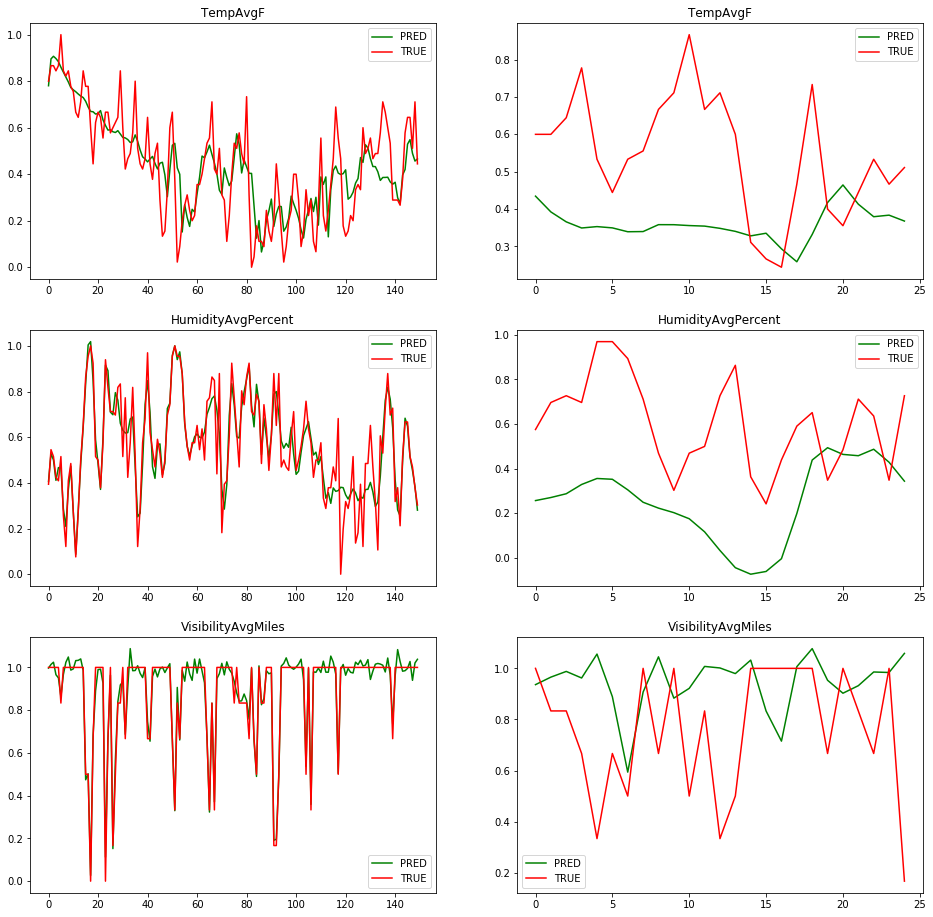

In [101]:
fig, axes = plt.subplots(3, 2, figsize = (16, 16))
plt.subplot(321, title=f'{name[0]}')
plt.plot(pred[:150,0], 'g', label='PRED')
plt.plot(labels_n[5:155,0], 'r', label='TRUE')
plt.legend(loc='best')
plt.subplot(322, title=f'{name[0]}')
plt.plot(pred[150:,0], 'g', label='PRED')
plt.plot(labels_n[155:,0], 'r', label='TRUE')
plt.legend(loc='best')

plt.subplot(323, title=f'{name[1]}')
plt.plot(pred[:150,1], 'g', label='PRED')
plt.plot(labels_n[5:155,1], 'r', label='TRUE')
plt.legend(loc='best')
plt.subplot(324, title=f'{name[1]}')
plt.plot(pred[150:,1], 'g', label='PRED')
plt.plot(labels_n[155:,1], 'r', label='TRUE')
plt.legend(loc='best')

plt.subplot(325, title=f'{name[2]}')
plt.plot(pred[:150,2], 'g', label='PRED')
plt.plot(labels_n[5:155,2], 'r', label='TRUE')
plt.legend(loc='best')
plt.subplot(326, title=f'{name[2]}')
plt.plot(pred[150:,2], 'g', label='PRED')
plt.plot(labels_n[155:,2], 'r', label='TRUE')
plt.legend(loc='best')

plt.show()

### 3.4 Using temperature, humidity and visibility to predict gas consumption

In [102]:
# Use temperature, humidity and visibility from 2015-9-30 to 2016-3-27, 180 days in total
baseline_date = datetime.datetime.strptime('2015-09-30', "%Y-%m-%d")
end_date = datetime.datetime.strptime('2016-03-27', "%Y-%m-%d")
df_weather = df_austin_weather[(df_austin_weather['Date']>= baseline_date)&(df_austin_weather['Date']<= end_date)]

In [103]:
# Split train & test set: first 150 timepoints to train and last 30 timepoints to test
labels = df_weather[['TempAvgF','HumidityAvgPercent','VisibilityAvgMiles']].values
labels = labels.astype('int64')
min_value = labels.min(axis=0)
max_value = labels.max(axis=0)
#  feature normalization: applying Min_max normalization method
norm_labels = (labels - min_value)/(max_value-min_value)   

x_train = norm_labels[:150,:]
x_val = norm_labels[150:,:]
y_train = train_set[:,np.newaxis]
y_val = val_set[:,np.newaxis]

In [104]:
# Applying XGBoost to train and predict
dtrain = xgb.DMatrix(x_train, label= y_train)
dtest = xgb.DMatrix(x_val, label = y_val)
param = {
#     'gamma': 0.4,
    'objective': 'reg:linear',
    'max_depth': 5,
    'lambda': 0.1,
    'subsample': 0.8,
    'eta': 0.01,
    'alpha': 0.1,
    'seed': 1000,
    'nthread': 1,
    'eval_metric': 'mae'
}
# watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_rounds = 1000
plst = param.items()
bst = xgb.train(plst, dtrain, num_rounds)
yhat = bst.predict(dtest)


[12:33:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Training evaluation:
Normalized gas consumption MSE: 0.0032244982854537016
Normalized gas consumption MAE: 0.03640810737544731
Gas consumption MSE: 3741734.4887658698
Gas consumption MAE: 1240.2336534386422
Test evaluation:
Normalized gas consumption MSE: 0.01082006052248638
Normalized gas consumption MAE: 0.07454986538717182
Gas consumption MSE: 12555687.751536455
Gas consumption MAE: 2539.5237098988355


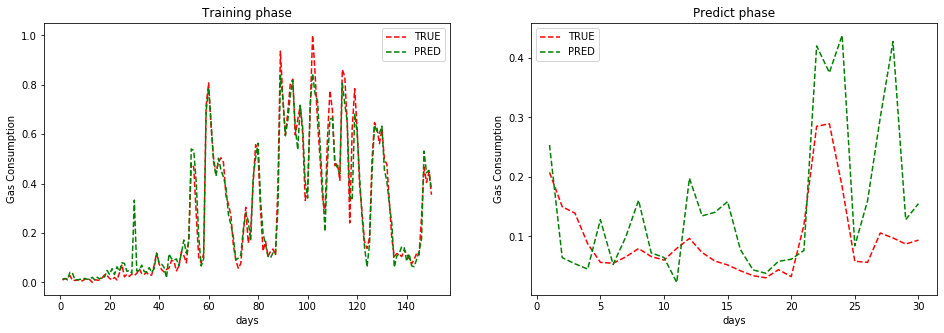

In [105]:
# plot training result and real gas consumption
x_pred = xgb.DMatrix(x_train)
y_train_pred = bst.predict(x_pred)
y1 = y_train
y2 = y_train_pred.tolist()
x = []
for ii in range(150):
    ii += 1
    x.append(ii)
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax1.plot(x,y1,'r--',label='TRUE')
ax1.plot(x,y2,'g--',label='PRED')
plt.xlabel('days')
plt.ylabel('Gas Consumption')
plt.title('Training phase')
ax1.legend()

# plot test result and real visibility
y11 = y_val
y22 = yhat.tolist()
x = []
for ii in range(30):
    ii += 1
    x.append(ii)
ax2 = fig.add_subplot(122)
ax2.plot(x,y11,'r--',label='TRUE')
ax2.plot(x,y22,'g--',label='PRED')
plt.xlabel('days')
plt.ylabel('Gas Consumption')
plt.title('Predict phase')
ax2.legend()

y1 = np.array(y1)
y2 = np.array(y2)
print('Training evaluation:')
print('Normalized gas consumption MSE:',mean_squared_error(y1, y2))
print('Normalized gas consumption MAE:',mean_absolute_error(y1, y2))
y1 = y1 * (max(comb_daily_reading)-min(comb_daily_reading)) + min(comb_daily_reading)
y2 = y2 * (max(comb_daily_reading)-min(comb_daily_reading)) + min(comb_daily_reading)
print('Gas consumption MSE:',mean_squared_error(y1, y2))
print('Gas consumption MAE:',mean_absolute_error(y1, y2))
y1 = np.array(y11)
y2 = np.array(y22)
print('Test evaluation:')
print('Normalized gas consumption MSE:',mean_squared_error(y1, y2))
print('Normalized gas consumption MAE:',mean_absolute_error(y1, y2))
y1 = y1 * (max(comb_daily_reading)-min(comb_daily_reading)) + min(comb_daily_reading)
y2 = y2 * (max(comb_daily_reading)-min(comb_daily_reading)) + min(comb_daily_reading)
print('Gas consumption MSE:',mean_squared_error(y1, y2))
print('Gas consumption MAE:',mean_absolute_error(y1, y2))